# Training Deep Neural Nets
page 275<br>
See
- https://github.com/ageron/handson-ml/blob/master/11_deep_learning.ipynb
- http://goo.gl/1rhAef (Xavier Glorot and Yoshua Bengio publication)
- http://goo.gl/VHP3pB (K. He *et al.* publication),
- http://goo.gl/gA4GSP (Sergey Ioffe and Christian Szegedy),
- https://arxiv.org/pdf/1706.02515.pdf (Günter Klambauer, Thomas Unterthiner, and Andreas Mayr publication),
- https://stackoverflow.com/questions/2976452/whats-is-the-difference-between-train-validation-and-test-set-in-neural-netwo (training, validation, and test sets),
- http://goo.gl/dRDAaf (gradient clipping),
- and for details.

When training (very) deep neural networks, a number of problems are likely to arise:
- The tricky **vanishing gradiens** and **exploding gradients** problems affects deep neural networks and makes it difficult to train lower lying layer efficiently.
- For a very large network, training will usually be very slow.
- A model with millions of parameters is likely to overfit.

All these problems – and possible solutoins – will be addressed in this chapter.
## Vanishing/Exploding Gradients Problems
page 275<br>
As discussed in chapter 10, backpropagation calculates all the gradients in passing the graph twice: first in the forward direction to compute each node's output and then in the backward direction to calculate all the gradients (using the node values from the forward pass). Unfortunately, the gradienst tend to become smaller and smaller during the backward pass so that the gradients are very small in the lower layers. This makes it difficult to train the lower layers. This is the **vanishing gradient problem**. For the related **exploding gradient problem**, the gradients become larger and larger for lower and lower layers. thus making the algorithm diverge due to too large update steps. The latter is mainly observed in recurrent neural networks (see chapter 14).<br>
As Xavier Glorot and Yoshua Bengio found in 2010 (see publication link above), the vanishing gradient problem can be caused by an unfortunate combination of weight initialization (radnomly with Gaussian distribution of mean 0 and standard deviation 1) and activation function (sigmoid). They found that in the forward pass, the variance increases from layer to layer, thus leading to large [small] gradients in the top [lower] layers.<br>
For illustration, the logistic function (sigmoid,see chapter 4) saturates for large (positive or negative) values. So even when the (large) input changes a lot, the output changes almost not at all.
### Xavier and He Initialization
page 277<br>
Glorot and Bengio argued that the signal needs to flow properly both forward (for predictions during inference) and backward (for weight updates during training). To achieve that, the variance of the outputs should be equal to the variance of the inputs. Additionally, the gradients (derivatives of the signal) also should all have equal variance, too. While it is not possible to guarantee equal variance throughout the network for both (i) signal and (ii) gradients, optimization is still possible. For a logistic activation function, **Xavier-** or **Glorot initialization** (named after the first [last] name of the first author of the Glorot & Bengio paper) uses (see Equation 11-1 in the book)<br>
$$\text{a normal distribution with $\mu=0$ and }\sigma=\sqrt{\frac{2}{n_{\rm inputs}+n_{\rm outputs}}}\\
\text{or a uniform distribution between $-r$ and $+r$, with} r=\sqrt{\frac{6}{n_{\rm inputs}+n_{\rm outputs}}}\,,$$
where $n_{\rm inputs\,[outputs]}$ is the number of input [output] connections (also called **fan-in** and **fan-out**, respectively). When the number of inputs is roughly equal to the number of outputs (order of magintude), one may simply use $\sigma=1/\sqrt{n_{\rm inputs}}$ or $r=\sqrt{3}/\sqrt{n_{\rm inputs}}$.<br>
Similar best practices for initialization have been found for other activation functions, see the paper by He *et al.* linked above. An overview is shown in the table below (Table 11-1 in the book).

|Activation function|Uniform distribution [-r,r]|Normal distribution$\text{$\qquad$}$|
|-|-|-|
|Logistic|$r=\sqrt{\frac{6}{n_{\rm inputs}+n_{\rm outputs}}}$|$\sigma=\sqrt{\frac{2}{n_{\rm inputs}+n_{\rm outputs}}}$|
|Hyperbolic tangent|$r=4\sqrt{\frac{6}{n_{\rm inputs}+n_{\rm outputs}}}$|$\sigma=4\sqrt{\frac{2}{n_{\rm inputs}+n_{\rm outputs}}}$|
|ReLU (and variants)|$r=\sqrt{2}\sqrt{\frac{6}{n_{\rm inputs}+n_{\rm outputs}}}$|$\sigma=\sqrt{2}\sqrt{\frac{2}{n_{\rm inputs}+n_{\rm outputs}}}$|

By default `tf.layers.dense()` uses Xavier initialization with a uniform distribution. Changing to He initialization is as easy as follows.

In [1]:
# imports
%matplotlib inline
import numpy as np
import tensorflow as tf
from functools import partial
import os
import matplotlib
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import time
# function to reset the graph (always a good idea)
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
reset_graph()
# changing the initializing method from Xavier to He
n_inputs = 1 + np.random.randint(10)
n_hidden1 = 1 + np.random.randint(10)
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X") # placeholder for features
he_init = tf.contrib.layers.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_initializer=he_init, name="hidden1")
hidden1

/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:496: FutureWarning: Passing (type, 1) or 

<tf.Tensor 'hidden1/Relu:0' shape=(?, 4) dtype=float32>

**General note**<br>
He initialization considers only the fan-in [input connections], not the average between fan-in and fan-out [output connections] like in Xavier initialization. This is also the default for the `variance_scaling_initializer()` function, but you can change this by setting the argument `mode="FAN_AVG"`.
### Nonsaturating Activation Funcitons
page 279<br>
As Glorot and Bengio showed, the activation function is important. The sigmoid had been assumed to be a very good choice because nature employs activations that resemble the sigmoid very much. But it turns out that ReLUs work much better. And even the ReLU has its shortcomings: (i) it's derivative at 0 is not defined and (ii) it's derivative vanishes for negative values. The latter property leads to the phenomenon of dying ReLUs. In particular for large learning rates, it happens that a ReLU starts outputting 0. Due to the vanishing gradient, it is unlikely to continue learning – it is dead. In some cases, 50% of all ReLUs are dead after some training time (**dying ReLUs**). This has led to several versions of ReLU. The **leaky ReLU** outputs $\max(\alpha z,\,z)$ with $0<\alpha<1$. So for $z>0$, it is the ReLU and for $z<0$ it is similar to ReLU but it leaks out a finite gradient. A small [huge] leak corresponds to $\alpha=0.01[0.2]$. The leaky ReLU always outperforms the ReLU, see https://goo.gl/B1xhKn (they also found that $\alpha=0.2$ works better than $\alpha=0.01$). The **randomized leaky ReLU** (**RReLU**) uses a different $\alpha$ (within a given range) during training and fixed average during testing. RRelu performs well and also seems to act like a regularizer: it reduces the risk of overfitting. The **parametric leaky ReLU** (**PReLU**) uses $\alpha$ such that is learned during training. This outperforms ReLU on large datasets but leads to overfitting for small datasets. Finally, Djork-Arné Clevert *et al.* found that their proposed **exponential linear unit** (**ELU**, see Equation 11-2 in the book),<br><br>
$$\text{ELU}_{\alpha}(x)=\left\{\begin{array}0\alpha({\rm exp}(z)-1)&{\rm if}\quad z<0\\z&{\rm if}\quad z\geq0\end{array}\right.$$

outperforms all the ReLU variants in their experiment (http://goo.gl/USdl2P7). It has a few major differences compared to ReLU:
- It takes on negative values. So the average output is closer to 0, which helps reducing vanishing gradients problem. The limit for $z\to-\infty$ is $-\alpha$: a parameter that can be set or learned.
- No dying ELUs because the gradient never vanishes.
- Faster gradient descent because the gradient is smooth and hence jumps not as much back and forth.

However, it is also more demanding to compute (due to the exponential for $z<0$). During training, this time loss is overcompensated by the faster convergence (less steps). Still, ELUs do lead to slower inference.<br><br>
As for TensorFlow, a function for ELU is readily provided but leaky ReLUs need to be defined by the user, as shown below.

In [2]:
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X") # placeholder for features
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")
print(hidden1)
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X") # placeholder for features
hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
hidden1

Tensor("hidden1/Elu:0", shape=(?, 4), dtype=float32)


<tf.Tensor 'hidden1/Maximum:0' shape=(?, 4) dtype=float32>

Under certain conditions, the **Scaled Exponential Linear Unit** (**SELU**) can outperform the ELU activation function. The SELU was introduced in 2017 by Günter Klambauer, Thomas Unterthiner, and Andreas Mayr (see link above).
### Batch Normalization
page 282<br>
By the choice of the activation function (e.g. ELU) and the random initialization (e.g. He initialization) one can usually avoid the vanishing / exploding gradients problem at the very beginning of training. But it might come back during training! The cause is still that the magnitude of the inputs and outputs may change drastically from the top to the bottom layers. Sergey Ioffe and Christian Szegedy addressed this problem in their 2015 publication (see link above).<br>
Their technique, **Batch Normalization (BN)**, applies operations before and after the activation function: After the layer has computed weighted sums, these results are zero-centered (subtract the mean) and normalized (divide by the standard deviation) before being sent to the activation function. Then, the activation function's result is multiplied by a scalar factro $\gamma$ and added to scalar summand $\beta$, both of which are learnable parameters. So this lets the algorithm learn the optimal scale and mean of the inputs for each layer. The mean and standard deviation of the first step are calculated from the current mini-batch, hence the name. Equation 11-3 in the book shows the details:
- $\mu_B=\frac{1}{m_B}\sum_{i=1}^{m_B}\bar{x}^{(i)}$,
- $\sigma_B^2=\frac{1}{m_B}\sum_{i=1}^{m_B}\left(\bar{x}^{(i)}-\mu_B\right)^2$,
- $x'^{(i)}=\frac{x^{(i)}-\mu_B}{\sqrt{\sigma_B^2+\epsilon}}$,
- $z^{(i)}=\gamma x'^{(i)}+\beta$,

where $\mu_B$ is the mean over the mini-batch B, $\sigma_B$ is the according standard deviation, $m_B$ is the number of instances in the mini-batch, $x'^{(i)}$ is the zero-centered and normalized input, $\gamma$ is the scaling parameter of the layer, $\beta$ is the shifting parameter (offset) of the layer, $\epsilon$ is a tiny number to avoid division by zero (typically $10^{-5}$, also called *smoothing term*), and $z^{(i)}$ is the output of the BN operation: it is a scaled and shifted version of the inputs.<br>
During inference for a new instance, there is no mini-batch to take the mean and standard deviation from. So the values of the entire training set are used instead. They can be computed efficiently during training via a moving average. So in total, each batch normalization operation produces 4 learned parameters during training: $\beta$ (offset of output), $\gamma$ (scale of output), $\mu$ (mean / offset of input), and $\sigma$ (standard deviation / scale of input).<br>
Ioffe and Szegedy demonstrated that batch normalization improved all networks they experimented with. The vanishing gradients problem was so strongly decreased that they could employ saturating activation functions like tanh and sigmoid. Weight initialization was also less relevant. Much larger learning rates were possible. They note "Applied to a state-of-the-art image classification model, Batch Normalization achieves the same accuracy with 14 times fewer training steps, and beats the original model by a significant margin. [...] Using an ensemble of batch-normalized networks, we improve upon the best published result on ImageNet classification: reaching 4.9% top-5 validation error (and 4.8% test error), exceeding the accuracy of human raters." Finally, like a gift that keeps giving, Batch Normalization regularizes the algorithm.<br>
Nevertheless, BN still adds a little complexity. While the extra time for additional computations during training is overcompensated by larger convergence, it is not compensated during inference. So if predictions need to be very fast, using ELU activation together with He initialization might be more performant.<br><br>
**General note**<br>
You may find that training is rather slow at first while Gradient Descent is searching for the optimal scales and offsets for each layer, but it accelerates once it has found resonably good values.<br><br>
**Implementing Batch Normalization with TensorFlow**<br>
TensorFlow provides "tf.nn.batch_normalization()", which takes care of centering and scaling the input but does not take care of the running averages of $\mu$ and $\sigma$ for inference and also not for the scale $\gamma$ and offset $\beta$. They can be computed via own code but it is much more convenient to use `tf.layer.batch_normaliztaion()` instead. It takes care of everything. Let's see!

In [3]:
n_inputs = 28 * 28 # input (probably MNIST)
n_hidden1 = 300    # neurons in hidden layer 1
n_hidden2 = 100    # neurons in hidden layer 2
n_outputs = 10     # neurons in output layer
reset_graph()      # always a good idea
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")         # input placeholder
training = tf.placeholder_with_default(False, shape=(), name="training") # training node
print(training)    # see remark in markdown below
# first layer with batch normalization and elu activation function
hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")                  # hidden layer 1
bn1 = tf.layers.batch_normalization(hidden1, training=training,          # bn1
                                    momentum=0.9)
# "bn1" learns the (moving) mean and the standard deviation of the input as well as the ...
# ... offset and the  scale of the output; by passing "bn1 to the activation function, ...
# ... \gamma (scale) and beta (offset) are automatically taken into account
bn1_act = tf.nn.elu(bn1) # output of first hidden layer: \beta and \gamma are handled ...
                         # ... automatically by bn1 (tf.layers.batch_normalization())
# second layer with batch normalization and elu activation function (in principle as above)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training, momentum=0.9)
logits

Tensor("training:0", shape=(), dtype=bool)


<tf.Tensor 'batch_normalization_3/batchnorm/add_1:0' shape=(?, 10) dtype=float32>

The reason we use the `training` placeholder is to tell `tf.layer.batch_normalization()` whether it should use the current mini-batch's mean and standard deviation (for training) or the values from the entire training set (for inference). The fully connected layers `tf.layers.dense()` are not given an activation function because activation only takes place after the batch normalization operation.<br>
The `momentum` parameter is used to compute the moving average via an *exponential decay*:<br><br>
$$v'\leftarrow v'\times{\rm momentum}+v(1- {\rm momentum})\,,$$
<br>
where $v$ corresponds to the current mini-batch and $v'$ to the previous value of the moving average. Typically, $v$ is larger the larger the training set is (or the smaller the mini-batches are; previous mini-batches shall not be forgotten even if the training set is huge), e.g., $v=0.9,\,0.99$ or 0.999.<br>
The repetitive code above can be simplified using Python's `partial()` function, as shown below.<br><br>
Note: Python's partial function allows the user to fix variables of a function. For example, it can set $y=2$ for the function f(x,y), thus making it a function g(x)=f(x,2) with simpler syntax (see https://www.learnpython.org/en/Partial_functions for a tutorial).

In [4]:
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")         # these two lines are taken ...
training = tf.placeholder_with_default(False, shape=(), name='training') # ... from the github link above
my_batch_norm_layer = partial(tf.layers.batch_normalization,  # use python's partial function to fix ...
                              training=training,momentum=0.9) # ... the training and momentum arguments
hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)                            # input ("hidden1") still needs to be specified
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)                            # input ("hidden2") still needs to be specified
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)                # input ("logits_before_bn") still needs to be specified
logits

<tf.Tensor 'batch_normalization_3/batchnorm/add_1:0' shape=(?, 10) dtype=float32>

In this small example it may not look like a big improvement. But when a larger network needs to be defined, this can be very handy!<br>
The rest of the construction phase remains unchanged (define a cost function, create an optimizer, let it minimize the cost function, define an evaluation score, e.g. accuracy, create a saver, and so on). Execution is also very similar. Only the `training` placeholder needs to be set to `True` [`False`] during training [inference] and the running averages $\mu$ (centering a new instance) and $\sigma$ (scaling a new instance) need to be calculated. Setting the `training` placeholder to `True` during training is done *manually*. TensorFlow keeps the to-be-updated running averages in its `UPDATE_OPS` collection. We just need to retrieve this collection and tell TensorFlow to actully update them at each training iteration.

In [5]:
### book, github, and own ideas
reset_graph()                                                            # always a good idea
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")         # placeholder features
y = tf.placeholder(tf.int32, shape=(None), name="y")                     # placeholder for labels
# function for batch normalization
training = tf.placeholder_with_default(False, shape=(), name='training')
batch_norm_momentum = 0.9
my_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=batch_norm_momentum)
# function for fully conneced layers that use He initialization
he_init = tf.variance_scaling_initializer()
my_dense_layer = partial(tf.layers.dense, kernel_initializer=he_init)
# actual network with two hidden layers; both use python's partial function to quickly build batch-normalized layers
with tf.name_scope("dnn"):
    # 2 hidden layers and an output layer, all of them fully connected and with batch normalization
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)
# cost function node
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
# learning schedule
learning_rate = 0.01
n_epochs = 11
batch_size = 200
# training node
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
# evaluation node
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
#   accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
# initializer and saver nodes
init = tf.global_variables_initializer()
saver = tf.train.Saver()
# make training, testing, and validation sets for the MNIST dataset (note that the validation set is intended to ...
# ... avoid overfitting, e.g., via early stopping; and the test set is to evaluate the performance of the final model
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]
# make randomized batches of the specified size
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
### book
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)                # get the quantities that shall be ...
with tf.Session() as sess:                                                   # ... updated (mean and standard dev.)
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # book code deprecated - use github code
            sess.run([training_op, extra_update_ops],                        # amongst many things, the mean and ...
                     feed_dict={training: True, X: X_batch, y: y_batch})     # ... the standard deviation get updated
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        # own if-statement to reduce output (n_epochs has been increased)
        if epoch % 5 is 0:
            print(epoch, "Validation accuracy:", accuracy_val)
    save_path = saver.save(sess, "./tf_logs/11_Training/Batch_Norm/my_model_final.ckpt")

0 Validation accuracy: 0.9042
5 Validation accuracy: 0.9572
10 Validation accuracy: 0.9694


### Gradient Clipping
page 286<br>
The exploding gradients problem occurs mainly in recurrent neural networks. One technique to avoid this issue is to simply clip the gradients such that they do not exceed certain values, e.g., they may be clipped to the interval $[-c, +c]$, where $c>0$. This is called **Gradient Clipping** (see link above). Nowadays, people prefer Batch Normalization but is still useful to know about Gradien Clipping.<br>
TensorFlow optimizer's `minimize()` function calculates and applies the gradients automatically. For gradient clipping, this must be disentangled and controlled. An example is shown below. It uses the optimizer's `compute_gradients()` method, a function that clips the gradients, and the optimizer's `apply_gradients()` method.

In [6]:
### github
reset_graph() # always a good idea
# mnist and dnn architecture
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
# deep neural network with 5 hidden layers to produce large gradients
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")
# cost function
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
# learning rate
learning_rate = 0.01
### book and own code
# training with clipped gradients
with tf.name_scope("train"):
    threshold = 1.0                                              # clip gradient to interval [-1, +1]
    optimizer = tf.train.GradientDescentOptimizer(learning_rate) # define an optimizer
    grads_and_vars = optimizer.compute_gradients(loss)           # get the gradents
    capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_and_vars] # loop ...
# ... through the gradients and clip them with tensorflow's "clip_by_value" method
training_op = optimizer.apply_gradients(capped_gvs)          # apply the clipped gradients
### github
# evaluation node
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
# initializer and saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()
# schedule (learning rate already defined a few lines above)
n_epochs = 11
batch_size = 200
# run the session
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    save_path = saver.save(sess, "./tf_logs/11_Training/Clipping/my_clipped_model_final.ckpt")

0 Validation accuracy: 0.288
1 Validation accuracy: 0.7938
2 Validation accuracy: 0.8796
3 Validation accuracy: 0.9058
4 Validation accuracy: 0.9164
5 Validation accuracy: 0.9218
6 Validation accuracy: 0.9292
7 Validation accuracy: 0.9358
8 Validation accuracy: 0.938
9 Validation accuracy: 0.9416
10 Validation accuracy: 0.9456


## Reusing Pretrained Layers
page 287<br>
Training model with many parameters costs a lot of compute. So it is generally a good idea to reuse a model that has been very well trained on a similar task. Specifically, one can reuse the lower layer and only retrain the top layers. This is called **transfer learning**. A modification of the top layers is also possible. The idea behind is that lower level recognize low-level features. Those will usually be shared by very similar tasks. Only the higher level features really depend on the very specific task and those require retraining. This approach will not only be much quicker but it will also require much less data, since the lower layers do not require training anymore.<br><br>
**General note**<br>
If the input pictures of your new task don't have the same size as the ones used in the original task, you will have to add a preprocessing step to resize them to the size expected by the original model. More generally, transfer learning will only work well if the inputs have similar low-level features.
### Reusing a TensorFlow Model
page 287<br>
If the original model was trained (and saved) with TensorFlow, restoration of the entire model should be straightforward:
- Use `import_meta_graph()` to import the operations into the default graph.
- This will return an object (a "saver", yes) that can be used to import the model's state.
- To obtain the operations and tensors needed for training, one can use the graph's `get_operation_by_name()` and `get_tensor_by_name()` methods. The name of a tensor is the name of the operation that outputs it followed by `:0` (or `:i` if it is the i+1-th output).

In [7]:
reset_graph()
print("Important: 'filename'.ckpt.META!\n")
# import the model created for batch normalization
saver = tf.train.import_meta_graph("./tf_logs/11_Training/Batch_Norm/my_model_final.ckpt.meta")
X = tf.get_default_graph().get_tensor_by_name("X:0")
print(X)
y = tf.get_default_graph().get_tensor_by_name("y:0")
print(y)
Mean = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")
print(Mean)
loss = tf.get_default_graph().get_tensor_by_name("loss/loss:0")
print(loss)

Important: 'filename'.ckpt.META!

Tensor("X:0", shape=(?, 784), dtype=float32)
Tensor("y:0", dtype=int32)
Tensor("eval/accuracy:0", shape=(), dtype=float32)
Tensor("loss/loss:0", shape=(), dtype=float32)


If the pretrained model is not well documented, showing all its operations via the graph's `get_operations()` method is one option ...

In [8]:
op_count = 0
for op in tf.get_default_graph().get_operations():
    print(op.name)
    op_count += 1
op_count

X
y
training/input
training
hidden1/kernel/Initializer/truncated_normal/shape
hidden1/kernel/Initializer/truncated_normal/mean
hidden1/kernel/Initializer/truncated_normal/stddev
hidden1/kernel/Initializer/truncated_normal/TruncatedNormal
hidden1/kernel/Initializer/truncated_normal/mul
hidden1/kernel/Initializer/truncated_normal
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
batch_normalization/gamma/Initializer/ones
batch_normalization/gamma
batch_normalization/gamma/Assign
batch_normalization/gamma/read
batch_normalization/beta/Initializer/zeros
batch_normalization/beta
batch_normalization/beta/Assign
batch_normalization/beta/read
batch_normalization/moving_mean/Initializer/zeros
batch_normalization/moving_mean
batch_normalization/moving_mean/Assign
batch_normalization/moving_mean/read
batch_normalization/moving_variance/Initializer/ones
batch_normalizatio

save/RestoreV2_10/tensor_names
save/RestoreV2_10/shape_and_slices
save/RestoreV2_10
save/Assign_10
save/RestoreV2_11/tensor_names
save/RestoreV2_11/shape_and_slices
save/RestoreV2_11
save/Assign_11
save/RestoreV2_12/tensor_names
save/RestoreV2_12/shape_and_slices
save/RestoreV2_12
save/Assign_12
save/RestoreV2_13/tensor_names
save/RestoreV2_13/shape_and_slices
save/RestoreV2_13
save/Assign_13
save/RestoreV2_14/tensor_names
save/RestoreV2_14/shape_and_slices
save/RestoreV2_14
save/Assign_14
save/RestoreV2_15/tensor_names
save/RestoreV2_15/shape_and_slices
save/RestoreV2_15
save/Assign_15
save/RestoreV2_16/tensor_names
save/RestoreV2_16/shape_and_slices
save/RestoreV2_16
save/Assign_16
save/RestoreV2_17/tensor_names
save/RestoreV2_17/shape_and_slices
save/RestoreV2_17
save/Assign_17
save/restore_all


862

... and visualizing the graph in TensorBoard is another. For the latter, run a short session that uses a FileWriter to write the graph (due to the "saver" above, this should now be the default graph) to an `events` file. Then start TensorBoard and visualize the newly written file. Here, navigate to the folder containing the folder "tf_logs" and run "tensorboard --logdir tf_logs".<br>
**Note:** To show that indeed a *new* `events` file for graph visualization is been created, that file is written to different folder ("Batch_Norm") below.

In [9]:
with tf.Session() as sess:
    tf.summary.FileWriter("./tf_logs/11_Training/Batch_Norm", tf.get_default_graph())
print("Done. You can now visualize the final graph for Batch Normalization in TensorBoard.")

Done. You can now visualize the final graph for Batch Normalization in TensorBoard.


As the creator of a model, one shall make it easy for potential reusers to understand the graph by giving operations intuitive names and documenting them. Additionally, one can make dedicated collectoins for the most important operations, see below.

In [10]:
# if necessary at some point, investigate how a "collection" can be saved and restored
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops1", op)
X, y, accuracy, training_op = tf.get_collection("my_important_ops1")

With the original graph restored (not in the previous cell but in the one above it), it is possible to retrain the model with Batch Normalization. However, the input placeholders `X` and `y` as well as the `accuracy` and the `training_op` need to be restored. The placeholders are needed for feeding new input, the training operation is required to continue training, and the accuracy is needed to assess the training progress. This is intuitive. However, restoring these variables and operations would be **not so straightforward** if we did not have the original code further above. (Re-)Creating the graph for inspection and listing all the operations - both have been demonstrated above - might be helpful.

In [11]:
# combination of book, own code, and the github link above
reset_graph()
saver = tf.train.import_meta_graph("./tf_logs/11_Training/Batch_Norm/my_model_final.ckpt.meta")
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")
training_op = tf.get_default_graph().get_operation_by_name("train/GradientDescent")
with tf.Session() as sess:
    saver.restore(sess, "./tf_logs/11_Training/Batch_Norm/my_model_final.ckpt")
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    save_path = saver.save(sess, "./tf_logs/11_Training/Batch_Norm/my_retrained_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./tf_logs/11_Training/Batch_Norm/my_model_final.ckpt
0 Validation accuracy: 0.9704
1 Validation accuracy: 0.973
2 Validation accuracy: 0.9738
3 Validation accuracy: 0.9742
4 Validation accuracy: 0.9752
5 Validation accuracy: 0.9728
6 Validation accuracy: 0.976
7 Validation accuracy: 0.9764
8 Validation accuracy: 0.9766
9 Validation accuracy: 0.9788
10 Validation accuracy: 0.9776


If the original python code is available, one can also build the model from scratch instead of using `import_meta_graph()`. Even if `import_meta_graph()` is used to import the model, one may still neglect the upper layers, as shown in Figure 11-4 of the book. Additional or replacement layers can still be added on top of the remaining pretrained layers (see the github link above for details). However, two savers will be required in that case. Otherwise, TensorFlow will complain that the graphs do not match.<br><br>
**Tip or Suggestion**<br>
The more similar the tasks are, the more layers you want to reuse (starging with the lower layers). For very similar tasks, you can try keeping all the hidden layers and just replace the output layer.
### Reusing Models from Other Frameworks
page 289<br>
If the model to be reused was trained on another framework, the conversion can be quite an ordeal. The parameters need to be loaded and then assigned to TensorFlow in a quite manual way. As an example, the following code shows the assignment of weights and biases, assuming that they have already been loaded from another framework. The tricky part is to have tensorflow initialize the model parameters with those weights and biases. This is done by feeding the weights to the appropriate assignment nodes via a dictionary.

In [12]:
# everything from github, see link above
reset_graph()                             # always a good idea
n_inputs = 2                              # number of inputs
n_hidden1 = 3                             # number of neurons in the first (and here the only) hidden layer
original_w = [[1., 2., 3.], [4., 5., 6.]] # load the weights from the other framework
original_b = [7., 8., 9.]                 # load the biases from the other framework
# feature placeholder
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
# first (and here only) hidden layer
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] here, the rest of the network shall be built
# get a handle on TensorFlow's assignment nodes for the weights and biases of the layer "hidden1"
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
# initial weights and biases
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]
# global initializer
init = tf.global_variables_initializer()
# run a TensorFlow session
with tf.Session() as sess:
    # initialize global variables but assign the imported weights and biases of the first hidden layer; this is ...
    # ... achieved by feeding the imported weights to TensorFlow's assignment nodes (see above) through a dicionary
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # let's produce a small result: based on the 2 inputs, the 3 neurons proudce 3 outputs (using 2x3 imported ...
    # ... weights and 3 biases)
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


### Freezing the Lower Layers
page 290<br>
When a network that had been trained on a similar task has been imported (in some way) in order to be adapted to the actual task, it makes sense to keep the lower layers as they are, i.e., to **freeze the lower layers**. Then, training of the upper layer will be much quicker. The following code shows how to achieve that with the trained and saved model for *Gradient Clipping*.

In [13]:
### everything github
reset_graph()       # always a good idea
# architecure
n_inputs = 28 * 28  # MNIST
n_hidden1 = 300     # reused
n_hidden2 = 50      # reused
n_hidden3 = 50      # reused
n_hidden4 = 20      # new! (was 50 before)
n_outputs = 10      # new! (input is now the 4th layer with 20 outuputs but has been the 5th layer with 50 outputs)
# input
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
# dnn (vanilla)
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")            # reused ...
    hidden1_stop = tf.stop_gradient(hidden1)                                                  # ... frozen
    hidden2 = tf.layers.dense(hidden1_stop, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused ...
    hidden2_stop = tf.stop_gradient(hidden2)                                                  # ... frozen
    # the third layer is reused but produces output in a different format and thus required training (=> not frozen)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused but not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")      # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                              # new!
# loss (vanilla - no gradient clipping)
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
# evaluation (vanilla)
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
# training (vanilla)
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
print("Vanilla DNN defined and ready for training on MNIST.")

Vanilla DNN defined and ready for training on MNIST.


The variables that shall be reused are restored using a collection (see further above) and a `tf.train.saver` instance on which the `restore` method will be called during runtime. **Cleverly**, the collection is build using a **regular expression**, thus increasing the probability that variables related to hidden layer 1-3 are colllected (and then restored). See
- https://docs.python.org/3/library/re.html#regular-expression-syntax and
- the Jupyter tutorial notebook "LearningPythonTutorial.ipynb" for details.

Since no clipping but only freezing is done here, we save the ".ckpt" file (for the session) and an "events" file (for the graph) in the new folder "freezing_but_clipping".

In [14]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars)                                         # to restore layers 1-3
init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    init.run()
    # restore variables from the collection above
    restore_saver.restore(sess, "./tf_logs/11_Training/Clipping/my_clipped_model_final.ckpt")
    # resume training
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    tf.summary.FileWriter("./tf_logs/11_Training/freezing_but_clipping", tf.get_default_graph())
    save_path = saver.save(sess, "./tf_logs/11_Training/freezing_but_clipping/frozen.ckpt")

INFO:tensorflow:Restoring parameters from ./tf_logs/11_Training/Clipping/my_clipped_model_final.ckpt
0 Validation accuracy: 0.8938
1 Validation accuracy: 0.9214
2 Validation accuracy: 0.9312
3 Validation accuracy: 0.9362
4 Validation accuracy: 0.9366
5 Validation accuracy: 0.9356
6 Validation accuracy: 0.9398
7 Validation accuracy: 0.9388
8 Validation accuracy: 0.9398
9 Validation accuracy: 0.94
10 Validation accuracy: 0.9418


While a bit confusing, the graph clearly indicates that only the 4-th hidden layer and the output layer are being trained. This is achieved with the command `tf.stop.gradient(...)`, see further above.
### Caching the Frozen Layers
page 291<br>
The frozen lower layers will always produce the same output for the same input because they are not being trained. So it makes sense to compute the output of the frozen layers for every instance only once, make batches out of these outputs, and feed these batches to the upper layers that are being trained. This will save a lot of time. Yet, it might require a lot of RAM because the output of the last frozen layer might be much larger than the original input.

In [15]:
# wild mix of book and github
n_batches = len(X_train) // batch_size
with tf.Session() as sess:
    init.run()
    # import the same model as above for "Freezing the Lower Layers"
    restore_saver.restore(sess, "./tf_logs/11_Training/Clipping/my_clipped_model_final.ckpt")
    # cache the output (both for training and for validation sets) of the lower layers that are not being trained
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid})
    # now loop through epochs
    for epoch in range(n_epochs):
        # make batches out of the lower layers' output
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        # use these batches for training the non-cached layers
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})
        # calculate and print the accuracy on the validation set
        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

INFO:tensorflow:Restoring parameters from ./tf_logs/11_Training/Clipping/my_clipped_model_final.ckpt
0 Validation accuracy: 0.8976
1 Validation accuracy: 0.9222
2 Validation accuracy: 0.9316
3 Validation accuracy: 0.9356
4 Validation accuracy: 0.937
5 Validation accuracy: 0.9374
6 Validation accuracy: 0.9384
7 Validation accuracy: 0.9386
8 Validation accuracy: 0.939
9 Validation accuracy: 0.941
10 Validation accuracy: 0.9412


### Tweaking, Dropping, or Replacing the Upper Layers
page 292<br>
Most likely, the original output layer that has been trained on some task does not perform optimally on the new task. Often, the number of outputs does not even fit the new task. But also the layers just below the output layer usually require adjustment: they have adapted to high-level features that are relevant for the original task but they might not perform well on the new task. In contrast, low-level features are often common even among quite different tasks. So the lower layers can often be kept as in the original task but the upper layers - in particular the output layer - usually need adjustment.<br>
But what layers shall be kept? First, freeze all layers but the last, training only the output layer. Then unfreeze the next layer, check the performance and continue unfreezing / retraining more and more layers. The more training data is available, the more layer can be unfrozen.<br>
If performance does not improve enough and only little training data is available, try dropping the top hidden layer(s) (drop iteratively one top layer after another) altogether, freeze all lower ones, and train only the output layer. When a lot of training data is available, replacing the top layers or even adding more layers is also worth trying.
### Model Zoos
page 292<br>
In order to reuse an existing model for a similar task, one first needs to have that model. Fortunately, there are many sources **model zoos** (a model zoo is a collection of models):
- Your own collection. Establish and maintain it!
- TensorFlow's own model zoo https://github.com/tensorflow/models.
- Caffe's model zoo https://goo.gl/XI02X3, which can be converted to TensorFlow with Saumitro Dasgupta's converter https://github.com/ethereon/caffe-tensorflow.
- OpenAI on github, includling Reinforcement Learning  https://github.com/germain-hug/Deep-RL-Keras.
- Deep Reinforcement Learning with Keras https://modelzoo.co/model/deep-reinforcement-learning-for-keras.

### Unsupervised Pretraining
page 293<br>
If a dataset has only a small fraction of labelled instances and no model for a similar task is available (thus excluding freezing all but the top layer of such similar but nonexistent model), then one can use feature detectors such as *Restricted Boltzmann Machines* or *Autoenconders* to pretrain the model layer by layer, starting from the bottom. Each hidden layer is trained on the output of the previous pretrained layer. All previous layers remain frozen during pretraining of the next layer. When all layers have been pretrained, one can fine tune the output and possibly some of the top hidden layers with the labelled data while keeping the lower layer frozen (see also Figure 11-5 in the book).<br>
This is a long and tedious process but it was very common to train networks this way until batch normalization led to the breakthrough of backpropagation.
### Pretraining on an Auxiliary Task
page 294<br>
Another option is to create a labelled dataset - with labels and dataset being different but qualitatively similar to the the actual task - and train a network on this dataset. Then, transfer learning can be used as described above.<br>
Say you want to classifiy photos of your friends according to the names of your friends in the photo. Then you could download a lot of photos from, say, actors and train a network to tell whether two photos show the same person (after labelling it manually). This network must have learned a lot about detecting faces so its lower-level hidden layers should be useful for your actual task.
## Faster Optimizers
page 295<br>
Training large DNNs can be painstakingly slow. So far, we have learned 4 techniques to make training faster:
- Good choice of parameter initialization (Xavier or He),
- good choice of activation function (ELU, for example),
- batch normalization (noramlizing the output of a layer wrt. mean and standare deviation before sending it to the activation function, then learning the scale and offset after the activation function), and
- reusing pretrained models (usually freezing the lower layers).

Using a well suited optimizer is another technique that can speed up training tremendously. The most popular ones,
- Momentum optimization,
- Nesterov Accelerated Gradient,
- AdaGrad,
- RMSProp,
- and Adam optimization

are presented below.
### Momentum Optimization
page 295<br>
Just like a ball picks up momentum as it rolls down a slope with a constant (and finite) gradient, the Momentum Optimizer also picks up speed: it adds the local gradient - multiplied by the learning rate $\eta$ - to the **momentum vector** $m$ and then updates the weights and biases ($\theta$) by simply subtracting $m$, see Equation 11-4 in the book:
$$m\leftarrow\beta m+\eta\nabla_{\theta}J(\theta)\,,\quad\theta\leftarrow\theta-m\,.$$
<br>
The hyperparameter $\beta$ is simply referred to as **momentum** and must be set between 0 (no momentum, high friction) and 1 (full momentum, no friction). For terminal momentum, the current and next $m$ have the same value and "$\leftarrow$" can be replaced by "$=$" in the (first) above equation and on may resolve the terminal momentum
$$m_{\rm terminal}=\frac{\eta}{1-\beta}\nabla_{\theta}J(\theta)\,,$$
<br>
which - for $\beta=0.9$ - is 10 times faster than default gradient descent. This allows Momentum Optimization to leave plateaus much faster. It is also more likely to *roll* past local optima. Implementation in TensorFlow is simple, just use the following `optimizer`.

In [16]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)

One might argue that the extra hyperparameter $\beta$ is a drawback since it must be determined. But in most cases $\beta=0.9$ works out of the box and much faster than default GradientDescent.<br><br>
**General note**<br>
Due to the momentum, the optimizer may overshoot a bit, then come back, overshoot again, and oscillate like this many times before stabilizing at the minimum. This is one of the reasons why it is good to have a bit of friction in the system: it gets rid of these oscillations and thus speeds up convergence.
### Nesterov Accelerated Gradient
page 297<br>
In contrast to vanilla Momentum Optimization, Nesterov Momentum optimization or **NAG** for **Nesterov Accelerated Gradient** (proposed by Yurii Nesterov in 1983, see https://goo.gl/V011vD) measures the gradient not at the local position $\theta$ but slightly down the road at $\theta+\beta m$, where $m$ is again the momentum:
- Momentum Optimization updates the momentum via $\qquad m\leftarrow\beta m+\eta\nabla_{\theta}(\theta)\qquad$ and
- Nesterov Accelerated Gradient via $\qquad\hspace{+3.06cm} m\leftarrow\beta m+\eta\nabla_{\theta}(\theta+\beta m)\quad$.

This makes sense because usually the gradient does not change abruptly and so Nesterov's gradient is closer to the average gradient along the step. Due to this, NAG also helps reduce oscillations. NAG will almost always be faster than vanilla Momentum Optimization. To use it, one just needs to set `use_nesterov=True`, as shown below.

In [17]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)

### AdaGrad
page 298<br>
Imagine a cost function that form an elongated bowl. Vanilla gradient descent would go down the steepest slope and then spend a lot of time crawling along the shallow valley towards the minimum. It would be much better to aim more directly to the minimum from the beginning on. The **AdaGrad** - short for "Adaptive Subgradient Methods for Online Learning and Stochatic Optimization" (http://goo.gl/4Tyd4j) - algorithm aims to solve this by scaling the gradient components. The vector $s$ accumulates the squares of the gradients and is then used to rescale the learning rate $\eta$ dependent on the component of the gradient (see Equation 11-6 in the book):
$$s\leftarrow s+\nabla_{\theta}J(\theta)\otimes\nabla_{\theta}J(\theta)\,,\quad\theta\leftarrow\theta-\eta\nabla_{\theta}J(\theta)\oslash\sqrt{s+\epsilon}\,.$$

The symbol $\otimes$ ($\oslash$) denotes element-wise multiplication (division). The smoothing term $\epsilon$ is usually chosen to be $10^{-10}$ and avoids division by zero.<br>
AdaGrad is often useful for simple quadratic problems but tends to stop too early when training artificial neural networks. So while TensorFlow does provide an `AdagradOptimizer`,

In [18]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

, it might not be the optimal choice for training DNNs.
### RMSProp
page 300<br>
This algorithm improves AdaGrad by slowly decaying the influence of previous contributions to the vector $s$ via the decay rate $\beta$ (Equation 11-7 in the book):<br><br>
$$s\leftarrow\beta s+(1-\beta)\nabla_{\theta}J(\theta)\otimes\nabla_{\theta}J(\theta)\,,\quad\theta\leftarrow\theta-\eta\nabla_{\theta}J(\theta)\oslash\sqrt{s+\epsilon}\,.$$
<br>
A decay rate of $\beta=0.9$ usually works very well. So although formally, $\beta$ is a new hyperparameter, there is often no need to tune it. Apart from very simple problems, RMSProp usually performs much better than AdaGrad and converges faster than Momentum Optimization and Nesterov Accelerated Gradient. Many considered it the best default optimizer until Adam Optimization came around. There is no formal paper for RMSProp, so people often cite "slide 29 in lecture 6" of Geoffrey Hinton's Coursera class (see http://goo.gl/RsQeis and https://goo.gl/XUbIyJ). TensorFlow's implementation,

In [19]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=0.9, decay=0.9, epsilon=1e-10)

, also uses "momentum", probably referring to Momentum Optimization. This can be avoided by setting `momentum=0.0`, see https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer for details.
### Adam Optimization
page 300<br>
*Adam* (https://goo.gl/Un8Axa) stands for *adaptive moment estimation* and combines Momentum Optimization and RMSProp by keeping track of exponentially decaying averages of (i) past gradients (for momentum) and (ii) past squares of gradient components (for component-wise scaling of the learning rate). For each iteration $T$, both decaying averages are rescaled before being used. That rescaling is useful because both averages are initialized to 0 and thus would be inconveniently small for early iterations. Equation 11-8 in the book summarizes the algorithm:
1. $m\leftarrow\beta_1m+(1-\beta_1)\nabla_{\theta}J(\theta)$,
2. $s\leftarrow\beta_2s+(1-\beta_2)\nabla_{\theta}J(\theta)\otimes\nabla_{\theta}J(\theta)$,
3. $m\leftarrow\frac{m}{1-\beta_1^T}$,
4. $s\leftarrow\frac{s}{1-\beta_2^T}$,
5. $\theta\leftarrow\theta-\eta m\oslash\sqrt{s+\epsilon}$.

Typical hyperparameter choices are $\beta_1=0.9$, $\beta_2=0.999$, and $\epsilon=10^{-8}$. These are also the default values of the TensorFlow class, as shown below.

In [20]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

Adam, AdaGrad, and RMSProp are adaptive optimizers and thus need less manual tuning of the learning rate $\eta$. A good default value is $\eta=0.001$. With these values working usually well, Adam Optimization is even simpler to use than vanilla Gradient Descent.<br><br>
**Warning / caution**<br>
This book initially recommended using Adam optimization, because it was generally considered faster and better than other methods. However, a 2017 paper (https://goo.gl/NAkWIa) by Ashia C. Wilson *et al.* showed that adaptive optimization methods (i.e., AdaGrad, RMSProp, and Adam optimization) can lead to solutions that generalize poorly on some datasets. So you may want to **stick to Momentum optimization or Nesterov Accelerated Gradient** for now, until researchers have a better understanding of this issue.<br><br>
**Training Sparse Models**<br>
All the optimization algorithms just presented produce dense models, meaning that most parameters will be nonzero. If you need a blazingly fast model at runtime, or if you need it to take up less memory, you may prefer to end up with a sparse model instead.<br>
One trivial way to achieve this is to train the model as usual, then get rid of the tiny weights (set them to 0).<br>
Another otpion is to apply strong $l_1$ regularization during training, as it pushes the optimizer to zero out as many weights as it can (as discussed in Chapter 4 about Lasso Regression).<br>
However, in some cases these techniques may remain insufficient. One last option is to apply *Dual Averaging*, often called *Follow The Regularied Leader* (FTRL), a techniuqe proposed by Yurii Nesterov (https://goo.gl/xSQD4C). When used with $l_1$ regularization, this technique often leads to very sparse models. TensorFlow implements a variant of FTRL called *FTRL-Proximal* (https://goo.gl/bxme2B) in the `FTRLOptimizer` class.<br><br>
All optimizers that have been introduced here only use the first-order partial derivatives (*Jacobians*). In addition, there are interesting optimizers that also use the **second-order partial derivatives (*Hessians*)**. However, these optimizers are very hard to apply to DNNs because with $n$ parameters, there are $n$ Jacobians and $n^2$ Hessians. With typically $n>10^4$ (or even $n>10^6$), the Hessians often **do not even fit in memory**. And if the do, it still takes a long time to compute them.
### Learning Rate Scheduling
page 303<br>
The correct learning rate is important: a too large learning rate will have the algorithm jump around the minimum, possibly even going further and further away from it and a too small learning rate will surely get very close to the minimum but will usually take a very, very long time to get there. *Learning schedules* (briefly introduced in Chapter 4 can speed up the process of getting very close to the minimum by gradually adjusting the learning rate. Here is a list of the most common learning schedules:
- *Predetermined piecwiese constant learning rate*<br>
For example, set the learning rate to $\eta_0=0.1$ at first, the to $\eta_1=0.001$ after 50 epochs. Although this solution can work very well, it often requires fiddling around to figure out the right learning rates and when to use them.
- *Performance scheudling*<br>
Measure the validation error every $N$ steps (just like for early stopping) and reduce the learning rate by a factor of $\lambda$ when the error stops dropping.
- *Exponential scheduling*<br>
Set the learning rate to a function of the iteration number $t:\,\eta(t)=\eta_010^{-t/r}$. This works great, but it requires tuning $\eta_0$ and $r$. The learning rate will drop by a factor of 10 every $r$ steps.
- *Power scheduling*<br>
Set the learning rate to $\eta(t)=\eta_0(1+t/r)^{-c}$. The hyperparameter $c$ is typically set to 1. This is similar to exponential scheduling, but the learning rate drops much more slowly.

In their 2013 paper (http://goo.gl/Hu6Zyq), Andreq Senior *et al.* compared different learning schedules on a speech recognition task and found that both performance scheduling and exponential scheduling performed well. They slightly favor exponential decay because it is simple to implement, easy to use, and it converged slightly faster. A TensorFlow implementation is shown below.

In [21]:
### github
# some shallow dnn for MNIST
reset_graph()
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
### book
# training node with learning rate schedule (name_scope not shown in book)
with tf.name_scope("train"):
    initial_learning_rate = 0.1 # start with this learning rate
    decay_steps = 10000         # stop decaying the learning rate after 10000 steps
    decay_rate = 1/10           # decrease the learning rate by factor of 1/e every 10 steps
    global_step = tf.Variable(0, trainable=False, name="global_step")               # count the steps, starting from 0
    learning_rate = tf.train.exponential_decay(initial_learning_rate,               # let tf update learning rate ...
                                               global_step,decay_steps, decay_rate) # ... according to parameters
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)             # pass learning rate to optimizer
    training_op = optimizer.minimize(loss, global_step=global_step)                 # use optimizer for training op
### github
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 5
batch_size = 50
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        ### own formatting and additional outputs "global_step" and "learning_rate"
        print("\nepoch:\t\t", epoch, "\tvalidation accuracy:\t", accuracy_val)
        print("global step:\t", global_step.eval(), "\tlearning_rate:\t\t", learning_rate.eval())


epoch:		 0 	validation accuracy:	 0.9618
global step:	 1100 	learning_rate:		 0.077624716

epoch:		 1 	validation accuracy:	 0.9754
global step:	 2200 	learning_rate:		 0.060255956

epoch:		 2 	validation accuracy:	 0.975
global step:	 3300 	learning_rate:		 0.04677352

epoch:		 3 	validation accuracy:	 0.9828
global step:	 4400 	learning_rate:		 0.036307808

epoch:		 4 	validation accuracy:	 0.9812
global step:	 5500 	learning_rate:		 0.02818383


AdaGrad, RMSProp and Adam optimization rescale the learning rate already so they do not require learning scheduling. But for other optimizers, in particular for Momentum Optimization and Nesterov Accelerated Gradient, Exponential Scheduling can considerably speed up convergence.
## Avoiding Overfitting Through Regularization
page 305<br>
"With four parameters I can fit an elephant and with five I can make ihim wiggle his trunk." –– John von Neumann, *cited by Enrico Fermi in Nature 427*<br><br>
DNNs can have millions of parameters. This allows them to learn complex function but also makes them prone to overfitting on the training set. Regularization helps avoid overfitting. And this section is about regularizing with TensorFlow using *early stopping*, *$l_1$* and *$l_2$ regularization*, *dropout*, *max-norm regularization*, and *data augmentation*.
### Early Stopping
page 305<br>
First introduced in Chapter 4, **early stopping** is a great way to avoid overfitting: simply stop training (=fitting) the model once the performance on the validation set drops. To this end, evaluate the performance on the validation set during training and stop training when the performance has dropped and did not recover after, say 5 (feel free to adjust), epochs. During training, always save the best model so it can be recovered after stopping early.<br>
Early stopping works wonderfully but usually one can still increase performance by combining it with another regularization technique.
### $l_1$ and $l_2$ Regularization
page 305<br>
Just as in Chapter 4, **$l_1$ and $l_2$ regularization** can be implemented by adding a term to the loss function that is the bigger the larger the $l_1$- and $l_2$-norms, respectively, of the DNN's weights (but usually not its biases) are. There are at least two ways to do this with TensorFlow. The first, rather manual is shown below.<br>
[In Chapter 4, look for "Ridge Regression" ($l_2$, page127), "Lasso Regression" ($l_1$, page 130, and "Elastic Net" (mix of $l_1$ and $l_2$, page 132).]

In [22]:
### book and gitub
reset_graph() # always a good idea
# architecture
n_inputs = 28 * 28 # MNIST
n_hidden1 = 300    # layer 1
n_outputs = 10     # output (number of classes)
# inputs
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X") # feature batch placeholder
y = tf.placeholder(tf.int32, shape=(None), name="y")             # label batch placeholder
# building
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")
# retrieve the weights (not the biases)
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")
# regularization hyperparameter
scale = 0.001
# construction of the combined (!) loss
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits) # cross entropy
    # the output of the above has the same shape as "y" => one output for every instance of the batch ...
    # ... so we need to average the output (over all instances in the batch) to obtain a single scalar;
    # for details, see: https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")          # mean loss of cross entropy
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2)) # scalar sum of regularization in both layers
    loss = tf.add(base_loss, scale * reg_losses, name="loss")          # combined loss
### just github
# evaluation
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)                  # is the label y among the top k (here, k=1) logits?
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), # accuracy
                              name="accuracy")
# learning schedule
learning_rate = 0.01
n_epochs = 6       # adapted from default 20 for brevity
batch_size = 200
# training node
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
# initialization and saving
init = tf.global_variables_initializer()
saver = tf.train.Saver()
# let the session begin
with tf.Session() as sess:
    # initialize all variables
    init.run()
    # loop over epochs
    for epoch in range(n_epochs):
        # shuffle the data, make batches, and feed them for training
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        # in each epoch, after training on all batches, check and print the accuracy on the validation set
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    # saving is skipped, here (although shown on github)

0 Validation accuracy: 0.831
1 Validation accuracy: 0.871
2 Validation accuracy: 0.8838
3 Validation accuracy: 0.8934
4 Validation accuracy: 0.8966
5 Validation accuracy: 0.8988


This "manual" way is a bit invconvenient if there are many layers. In that case, TensorFlow's own implementation might be useful: many functions that create trainable variables accept a `*_regularizer` argument (e.g., `kernel_regularizer`). Passing a function the regularizer argument of choice will have it calculate the according loss. In the end, **all losses can be collected automatically**  and added to the cost function. There are many regularizers, including `l1_regularizer()`, `l2_regularizer()`, and `l1_l2_regularizer()`.<br>
The code below resembles the one above so only the changed parts are commented.

In [23]:
reset_graph()
n_inputs = 28 * 28
n_hidden1 = 300
n_outputs = 10
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
# regularization hyperparameter now appears here
scale = 0.001
# use partial function to simplify code (but not necessary)
my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu,
                        kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))
# build same dnn but in a different way (use above partial function, which uses regularization)
with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    logits = my_dense_layer(hidden1, n_outputs, activation=None, name="outputs")
# no need to retrieve the weights one by one via "tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")"
# construct the combined loss in a slightly different way (much easier for many layers)
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) # collect all regularization losses this easy!
    loss = tf.add_n([base_loss] + reg_losses, name="loss")             # combined loss
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
learning_rate = 0.01
n_epochs = 6
batch_size = 200
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()
# "saver" shown on github but deleted here and in session
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

0 Validation accuracy: 0.8118
1 Validation accuracy: 0.8624
2 Validation accuracy: 0.8782
3 Validation accuracy: 0.8856
4 Validation accuracy: 0.8932
5 Validation accuracy: 0.8966


**Warning / caution**<br>
Don't forget to add the regularization losses to your overall loss, or else they will simply be ignored.
### Dropout
page 307<br>
This is a very powerful and popular regularization technique that was introduced by G. E. Hinton in 2012 (https://goo.gl/PMjVnG) and further detailed in a paper (http://goo.gl/DNKZo1) by Nitish Srivastava *et al.*. Even on very performant networks it tends to give an accuracy boost of 1-2%. That is a lot if the network already had an accuracy of 95%. **Dropout** works by switching off / suppressing the output of every neuron in the network (including the input neurons but excluding the output neurons) with a **probability $p$ during training**. Dropout is not applied during inference. So during training, each neuron sees on average input from only $1-p$ times the neurons it sees during inference. To avoid that total input scale to a neuron is during training is the same as during inference one can
- divide each neuron's output by $1-p$ during training (implemented by TensorFlow with `tf.layers.dropout()`) or
- multiply a each neuron's input by $1-p$ during inference.

The quantity $1-p$ is also referred to as the **keep rate** since it is the number of neurons that are on average kept (= not dropped) during training.<br>
Say there are $N$ neurons in a network in each has to possible states during training: dropped or kept. That makes $2^N$ different neural networks, which is usually a humongous number since neural networks have often far more than 1000 parameters. In many cases the network will never be exactly the same for two training instances. And after training, the resulting network is actually a mixture (or average) of the networks that occurred during training.<br>
Dropout forces the network to be more resilient in that it does not rely strongly on individual neurons. Would a company also work better when each employee showed up only with probability $p=0.5$ on a given day? Maybe yes. The competences would be more distributed over the employees (neurons). The failure of one individual (due to a bad day - or due to bad input) could be better compensated by other employees (neurons). It would take longer for the company to run smooth but then it might do very well. Indeed, neural networks that use dropout usually take longer to train but then perform better. We shall try it out below!<br><br>
**Warning / caution**<br>
You want to use the `tf.layers.dropout()` function, not `tf.nn.dropout()`. The first one turns off (no-op) when not training, which is what you want, while the second one does not.

In [24]:
### own
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10
### github
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
### book
training = tf.placeholder_with_default(False, shape=(), name="training") # specify when training and when infering
dropout_rate = 0.5                                                       # "dropout rate" = 1 - "keep rate"
X_drop = tf.layers.dropout(X, dropout_rate, training=training)           # dropout for input neurons
with tf.name_scope("dnn"):                                               # build the dnn
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu, name="hidden1")       # layer 1 default
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)                # layer 1 dropout
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu, name="hidden2") # layer 2 default
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)                # layer 2 dropout
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")    # no dropout for output layer
### github
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
init = tf.global_variables_initializer()
# "saver" shown on github but deleted here and in session
n_epochs = 6 # adapted from default 20 for brevity
batch_size = 50
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})         # training "True" ...
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})                      # ... "False" (default)
        print(epoch, "Validation accuracy:", accuracy_val)

0 Validation accuracy: 0.9254
1 Validation accuracy: 0.9452
2 Validation accuracy: 0.9492
3 Validation accuracy: 0.9566
4 Validation accuracy: 0.9618
5 Validation accuracy: 0.9602


Dropout behaves differently during trainig (neurons are dropped out) and inference (no neurons are dropped out). So we need to tell the network when we are training and when not. In the code above, this is achieved with the placeholder `training`. We have done something like this also for batch normalization, where we needed to tell the network whether to calculate the mean and standard deviation of the input to the activation function over the current batch (for training) or take the running averages of these values calculated during training (for inference).<br><br>
**General note**<br>
*Dropconnect* is a variant of dropout where individual connections are dropped randomly rather than whole nerurons. In general dropout performs better.
### Max-Norm Regularization
page 309<br>
For each neuron, **max-norm regularization** constrains the weight vector $w$ for the incoming connections such that $|w|_2\leq r$, where the scalar $r>0$ is the max-norm hyperparameter. Decreasing $r$ increases the regularization. Regularization is implemented by rescaling the weights in the following way (if $|w|_2>r$):
$$w\leftarrow w\frac{r}{|w|_2}\,.$$
Usually, max-norm regularization is applied **to all layers' but the output layer's** neurons' kernels (=weights). Max-norm regularization is quite popular for neural networks and can help alleviate the vanishing / exploding gradients problem (if Batch Normalization is not used). There is no off-the-shelf implementation for TensorFlow but there are at least two ways to do it, again one is more *manual* and the other more *automatic* (and thus more convenient when many layers are used). In any case, we need to get a handle on the weights, normalize them, and feed them back. We start with the more manual implementation.

In [25]:
# by and large, the network is the same as before so only the max-norm regularization will be commented
### github
reset_graph()
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10
learning_rate = 0.01
momentum = 0.9
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
### book and own code (for second hidden layer; also on github)
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")   # get the weights / kernel
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)   # use "tf.clip_by_norm" for clipping ...
# ... them to the specified thrshold; https://www.tensorflow.org/api_docs/python/tf/clip_by_norm
clip_weights = tf.assign(weights, clipped_weights)                        # feed the clipped weights back
# do this same for all layers but the output layer
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")  # same as above ...
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1) # ... only with ...
clip_weights2 = tf.assign(weights2, clipped_weights2)                     # ... different names
### github
init = tf.global_variables_initializer()
# "saver" shown on github but deleted here and in session
n_epochs = 6 # adapted from default 20 for brevity
batch_size = 50
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            # book and own code (for second hidden layer; also on github)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()
        # github
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", acc_valid)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
0 Validation accuracy: 0.9568
1 Validation accuracy: 0.9702
2 Validation accuracy: 0.9718
3 Validation accuracy: 0.9774
4 Validation accuracy: 0.9772
5 Validation accuracy: 0.9782


It seems to work really well! But note that we have to build code for each and every layer to which we wish to apply max-norm regularization. Both for the construction and for the execution phase. This means a lot of work for very deep networks. The below code alleviates this problem by creating a `max_norm_regularizer()` function that can be assigned to a layer just like any other regularizer function, e.g., like `l1_regularizer()` (see demonstration further above).

In [26]:
### book
# define the regularizer function
def max_norm_regularizer(threshold, axes=1, name="max_norm", collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None
    return max_norm # this returns the function "max_norm", not the output of "max_norm(weights)"; in fact ...
                    # ... "max_norm(weights)" does not return output ("None"), it just adds the clipped weights ...
                    # ... "clip_weights" to the collection "max_norm"
# specify the threshold and leave the default values unchanged
max_norm_reg = max_norm_regularizer(threshold=1.0)
max_norm_reg

<function __main__.max_norm_regularizer.<locals>.max_norm(weights)>

Next, we feed this regularizer function simply to all layers but the output layer. But there is still more to be done! Max-norm regularization is not added to the cost function. It needs to be executed explicitly at runtime! So we retrieve the clipping collection `"max_norm"` and execute it **at runtime after the training operation but before calculating the accuracy** score on the validation set.

In [27]:
# by and large, the network is still the same so comments only where needed
### github
reset_graph()
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10
learning_rate = 0.01
momentum = 0.9
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1") # use "max_norm_reg" ...
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2") # ... as defined above
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
init = tf.global_variables_initializer()
# "saver" shown on github but deleted here and in session
n_epochs = 6                                                                   # adapted from default 20 for brevity
batch_size = 50
clip_all_weights = tf.get_collection("max_norm")                               # access all the weights for clipping
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)                                         # run the weight clipping
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", acc_valid)

0 Validation accuracy: 0.9556
1 Validation accuracy: 0.9706
2 Validation accuracy: 0.9688
3 Validation accuracy: 0.975
4 Validation accuracy: 0.9774
5 Validation accuracy: 0.976


Indeed, we needed to add much less code for each *additional* layer. Only the `regularizer` function needs to be specified for each layer. This could even be simplified with Python's `partial()` function, as we did for batch-normalization further above.
### Data Augmentation
page 311<br>
Artificially increasing the size of the training set by generating new instances out of the available data will reduce overfitting and thus counts as a regularization technique. Simply **adding noise does not work**: the applied modifications should be learnable. (Noise is not learnable since it is purely random.) At best, a human should not be able to tell which instances are original and which ones have been generated.<br>
In the context of pictures one may for example
- slightly translate the image,
- slightly rotate the image,
- mirror the image if the mirrored image still falls into this class (this does not work for the class of "left hands", for example),
- apply a slightly different light condition,
- or slightly change the contrast.

By **combining** these techniques, one can **significantly** augment the dataset. This also means that it often makes sense to generate new instances on the fly: storing the augmented dataset would consume a lot of memory. TensorFlow offers commands for a lot of data augmentation operations: shifting, rotating, resizing, flipping, cropping, and changing the brightness, contrast, saturation, or hue. In fact, there are even many more on the tensorflow website, see https://www.tensorflow.org/api_docs/python/tf/image.<br><br>
**General note**<br>
Another powerful technique to train very deep neural networks is to add *skip connections* (a skip connection is when you add the input of a layer to the output of a higher layer). We will explore this idea in Chapter 13 when we talk about deep residual networks.
### Practical Guidelines
page 312<br>
A lot of techniques for training DNNs have been introduced in this Chapter. The following cornerstones will usually be a good starting configuration:
- He initialization,
- ELU activation function,
- Batch Normalization,
- Dropout regularization,
- Nesterov Accelerated Gradient optimizer, and
- *no* learning rate schedule.

If possible, try to reuse (the lower layers of) a model that was trained on a similar task. Often, the above default configuration may need adjustment.
- Try a learning schedule (e.g. exponential decay) if adjusting the learning rate does not lead to fast convergence *and* good accuracy at the same time.
- Use data augmentation if the training set is too small.
- If a sparse model is needed, add $l_1$ regularization and possibly chop tiny weights to zero. If the model still needs to be more sparse, try out the *Following The Regularized Leader* (FTRL) optimizer. See above for more details.
- For lightning fast models at runtime, drop Batch Normalization, maybe replace ELU by leaky ReLU activation, and try to make the model as sparse as possible.

## Exercises
page 313
### 1.-7.
Solutions are shown in Appendix A of the book and in the separate notebook *ExercisesWithoutCode*.
### 8. Deep Learning.
- Build a DNN with five hidden layers of 100 neurons each, He initializatio, and the ELU activation function.
- Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later.
- Tune the hyperparameters using cross-validation and see what precision you can achieve.
- Now try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?
- Is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?

The entire solution is heavily based on the code from github. First, make a function that builds the desired DNN (with He initialization and ELU activation).

In [28]:
# we will need 2 DNNs so a function that takes care of the hidden layers is going to be handy
he_init = tf.variance_scaling_initializer()                  # He initializer
def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None, # function that builds a network and returns its output
        activation=tf.nn.elu, initializer=he_init):          # by default, use ELU activation and He initialization
    with tf.variable_scope(name, "dnn"):                     # build the network
        for layer in range(n_hidden_layers):                 # loop through the layers, always calculating the output
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer, name="hidden%d" % (layer + 1))
        return inputs                                        # return the last layers output
# build the network using the above function and additional code (for input and output)
n_inputs = 28 * 28
n_outputs = 5
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
dnn_outputs = dnn(X)                                         # here, use the above function
logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")              # softmax output with n_output=5 neurons
print(Y_proba)
print("first task accomplished")

Tensor("Y_proba:0", shape=(?, 5), dtype=float32)
first task accomplished


Now build the dataset (very efficiently), use Adam optimization, and softmax output with five neurons for classification. Run and save this model!

In [29]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
print([y_train < 5])                 # this here is very useful to ...
print(X_train1.shape, X_train.shape) # ... select a dataset with digits 0 to 4
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]
#
learning_rate = 0.01
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits) # "logits" uses above function ...
loss = tf.reduce_mean(xentropy, name="loss")                                       # ... and "x_entropy" uses softmax
optimizer = tf.train.AdamOptimizer(learning_rate)                                  # Adam optimization
training_op = optimizer.minimize(loss, name="training_op")
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
init = tf.global_variables_initializer()
saver = tf.train.Saver()
#
n_epochs = 16                        # changed from default 1000 for brevity
batch_size = 20
max_checks_without_progress = 5      # changed from default 20 for brevity
checks_without_progress = 0
best_loss = np.infty
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:                                                   # early stopping
            save_path = saver.save(sess, "./tf_logs/11_Training/Ex_8/my_mnist_model_0_to_4.ckpt") # path adapted
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))
with tf.Session() as sess:
    saver.restore(sess, "./tf_logs/11_Training/Ex_8/my_mnist_model_0_to_4.ckpt")                  # path adapted
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

[array([False,  True,  True, ..., False, False, False])]
(28038, 784) (55000, 784)
0	Validation loss: 0.142523	Best loss: 0.142523	Accuracy: 96.87%
1	Validation loss: 1.206604	Best loss: 0.142523	Accuracy: 42.03%
2	Validation loss: 0.271909	Best loss: 0.142523	Accuracy: 95.58%
3	Validation loss: 0.269873	Best loss: 0.142523	Accuracy: 94.53%
4	Validation loss: 0.196974	Best loss: 0.142523	Accuracy: 95.97%
5	Validation loss: 0.167328	Best loss: 0.142523	Accuracy: 97.26%
Early stopping!
INFO:tensorflow:Restoring parameters from ./tf_logs/11_Training/Ex_8/my_mnist_model_0_to_4.ckpt
Final test accuracy: 97.35%


To accomplish the next three tasks, we use the very fancy code from github. Apparently, it builds a Scikit-Learn-like classifier – using TensorFlow! – so that Scikit-Learn's `RandomizedSearchCV` can be applied in the default manner.

In [30]:
class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        # Initialize the DNNClassifier by simply storing all the hyperparameters.
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None
    def _dnn(self, inputs):
        # Build the hidden layers, with support for batch normalization and dropout.
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer, name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs
    def _build_graph(self, n_inputs, n_outputs):
        # Build the same model as earlier!
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)
        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")
        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None
        dnn_outputs = self._dnn(X)
        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")
        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()
        # Make the important operations available easily through instance variables!
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver
    def close_session(self):
        if self._session:
            self._session.close()
    def _get_model_params(self):
        # Get all variable values (used for early stopping, faster than saving to disk)!
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}
    def _restore_model_params(self, model_params):
        # Set all variables to the given values (for early stopping, faster than loading from disk)!
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)
    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        # Fit the model to the training set. If X_valid and y_valid are provided, use early stopping.
        self.close_session()
        # Infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        # Translate the labels vector to a vector of sorted class indices, containing integers from 0 to n_outputs-1.
        # For example, if y is equal to [8,8,9,5,7,6,6,6], then the sorted class labels (self.classes_) will be ...
        # ... equal to [5, 6, 7, 8, 9], and the labels vector will be translated to [3, 3, 4, 0, 2, 1, 1, 1].
        self.class_to_index_ = {label: index for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label] for label in y], dtype=np.int32)
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid, self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch, self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found!
            if best_params:
                self._restore_model_params(best_params)
            return self
    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})
    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)
    def save(self, path):
        self._saver.save(self._session, path)
# create an instance of the newly defined classifier class and train it (in a Scikit-Learn fashion)
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.142523	Best loss: 0.142523	Accuracy: 96.87%
1	Validation loss: 1.206604	Best loss: 0.142523	Accuracy: 42.03%
2	Validation loss: 0.271909	Best loss: 0.142523	Accuracy: 95.58%
3	Validation loss: 0.269873	Best loss: 0.142523	Accuracy: 94.53%
4	Validation loss: 0.196974	Best loss: 0.142523	Accuracy: 95.97%
5	Validation loss: 0.167328	Best loss: 0.142523	Accuracy: 97.26%
6	Validation loss: 0.202854	Best loss: 0.142523	Accuracy: 94.68%
7	Validation loss: 0.291291	Best loss: 0.142523	Accuracy: 95.70%
8	Validation loss: 0.186152	Best loss: 0.142523	Accuracy: 97.73%
9	Validation loss: 0.948319	Best loss: 0.142523	Accuracy: 69.66%
10	Validation loss: 0.329804	Best loss: 0.142523	Accuracy: 93.78%
11	Validation loss: 0.162550	Best loss: 0.142523	Accuracy: 97.07%
12	Validation loss: 0.138445	Best loss: 0.138445	Accuracy: 96.79%
13	Validation loss: 0.216108	Best loss: 0.138445	Accuracy: 96.29%
14	Validation loss: 0.170976	Best loss: 0.138445	Accuracy: 95.50%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x114248840>,
              batch_norm_momentum=None, batch_size=20, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x1247673c8>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

After initial training, check the accuracy on the test set.

In [31]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.974508659272232

Use `RandomizedSearchCV` to tune the hyperparameters and search for the best solution. Here, the hyperparamters are
- the number of neurons,
- the batch size,
- the learning rate, and
- the activation function.

The **Leaky ReLU** activation is explicitly defined, here.

In [32]:
def leaky_relu(alpha=0.01): # definition of Leaky ReLU
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu
param_distribs = {"n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
                  "batch_size": [10, 50, 100, 500],
                  "learning_rate": [0.01, 0.02, 0.05, 0.1],
                  "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)]}
                  # You could also try exploring different numbers of hidden layers, different optimizers, etc.
                  # "n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                  # "optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)]
rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs,
                                n_iter=10, cv=3, random_state=42, verbose=2) # default: n_iter=50
rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function elu at 0x114248840> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.145078	Best loss: 0.145078	Accuracy: 96.64%
1	Validation loss: 0.173971	Best loss: 0.145078	Accuracy: 95.19%
2	Validation loss: 0.157920	Best loss: 0.145078	Accuracy: 96.40%
3	Validation loss: 0.148727	Best loss: 0.145078	Accuracy: 96.48%
4	Validation loss: 0.137161	Best loss: 0.137161	Accuracy: 96.72%
5	Validation loss: 0.118723	Best loss: 0.118723	Accuracy: 96.64%
6	Validation loss: 0.111457	Best loss: 0.111457	Accuracy: 96.56%
7	Validation loss: 0.125656	Best loss: 0.111457	Accuracy: 96.91%
8	Validation loss: 1.649478	Best loss: 0.111457	Accuracy: 22.01%
9	Validation loss: 1.573059	Best loss: 0.111457	Accuracy: 23.26%
10	Validation loss: 1.571778	Best loss: 0.111457	Accuracy: 23.26%
11	Validation loss: 1.580718	Best loss: 0.111457	Accuracy: 21.42%
12	Validation loss: 1.591989	Best loss: 0.111457	Accuracy: 21.42%
13	Validation loss: 1.586365	Best loss: 0.111457	Accuracy: 21.07%
14	Validation loss: 1.586736	Best loss: 0.111457	Accuracy: 21.07%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.8s remaining:    0.0s


0	Validation loss: 0.132567	Best loss: 0.132567	Accuracy: 96.64%
1	Validation loss: 0.140460	Best loss: 0.132567	Accuracy: 96.48%
2	Validation loss: 0.140922	Best loss: 0.132567	Accuracy: 96.48%
3	Validation loss: 0.303073	Best loss: 0.132567	Accuracy: 95.43%
4	Validation loss: 0.324907	Best loss: 0.132567	Accuracy: 93.86%
5	Validation loss: 0.271279	Best loss: 0.132567	Accuracy: 94.21%
6	Validation loss: 0.205956	Best loss: 0.132567	Accuracy: 94.80%
7	Validation loss: 0.169514	Best loss: 0.132567	Accuracy: 96.21%
8	Validation loss: 0.293873	Best loss: 0.132567	Accuracy: 93.55%
9	Validation loss: 0.191498	Best loss: 0.132567	Accuracy: 95.04%
10	Validation loss: 0.215853	Best loss: 0.132567	Accuracy: 94.53%
11	Validation loss: 0.251179	Best loss: 0.132567	Accuracy: 92.42%
12	Validation loss: 0.187263	Best loss: 0.132567	Accuracy: 95.31%
13	Validation loss: 0.187945	Best loss: 0.132567	Accuracy: 95.47%
14	Validation loss: 0.379301	Best loss: 0.132567	Accuracy: 86.94%
15	Validation loss: 

0	Validation loss: 0.115925	Best loss: 0.115925	Accuracy: 96.36%
1	Validation loss: 0.076872	Best loss: 0.076872	Accuracy: 97.58%
2	Validation loss: 0.067116	Best loss: 0.067116	Accuracy: 98.01%
3	Validation loss: 0.058144	Best loss: 0.058144	Accuracy: 98.36%
4	Validation loss: 0.074449	Best loss: 0.058144	Accuracy: 98.16%
5	Validation loss: 0.054461	Best loss: 0.054461	Accuracy: 98.28%
6	Validation loss: 0.056603	Best loss: 0.054461	Accuracy: 98.44%
7	Validation loss: 0.055495	Best loss: 0.054461	Accuracy: 98.51%
8	Validation loss: 0.074740	Best loss: 0.054461	Accuracy: 98.24%
9	Validation loss: 0.064255	Best loss: 0.054461	Accuracy: 98.51%
10	Validation loss: 0.060270	Best loss: 0.054461	Accuracy: 98.40%
11	Validation loss: 0.054939	Best loss: 0.054461	Accuracy: 98.59%
12	Validation loss: 0.065591	Best loss: 0.054461	Accuracy: 98.67%
13	Validation loss: 0.074305	Best loss: 0.054461	Accuracy: 98.63%
14	Validation loss: 0.067463	Best loss: 0.054461	Accuracy: 98.28%
15	Validation loss: 

0	Validation loss: 57.873569	Best loss: 57.873569	Accuracy: 94.10%
1	Validation loss: 37.014317	Best loss: 37.014317	Accuracy: 91.16%
2	Validation loss: 13.864572	Best loss: 13.864572	Accuracy: 94.61%
3	Validation loss: 5.985952	Best loss: 5.985952	Accuracy: 96.33%
4	Validation loss: 5.117127	Best loss: 5.117127	Accuracy: 95.97%
5	Validation loss: 3.829853	Best loss: 3.829853	Accuracy: 95.74%
6	Validation loss: 2.736975	Best loss: 2.736975	Accuracy: 96.17%
7	Validation loss: 11.158143	Best loss: 2.736975	Accuracy: 92.42%
8	Validation loss: 7952236.500000	Best loss: 2.736975	Accuracy: 39.76%
9	Validation loss: 157717.359375	Best loss: 2.736975	Accuracy: 73.92%
10	Validation loss: 46322.695312	Best loss: 2.736975	Accuracy: 88.98%
11	Validation loss: 38651.398438	Best loss: 2.736975	Accuracy: 87.02%
12	Validation loss: 16216.562500	Best loss: 2.736975	Accuracy: 93.04%
13	Validation loss: 16141.016602	Best loss: 2.736975	Accuracy: 93.47%
14	Validation loss: 288146.875000	Best loss: 2.73697

25	Validation loss: 0.077421	Best loss: 0.048523	Accuracy: 98.44%
26	Validation loss: 0.103571	Best loss: 0.048523	Accuracy: 98.40%
27	Validation loss: 0.092265	Best loss: 0.048523	Accuracy: 98.40%
28	Validation loss: 2.922433	Best loss: 0.048523	Accuracy: 48.24%
29	Validation loss: 0.185260	Best loss: 0.048523	Accuracy: 96.25%
Early stopping!
[CV]  n_neurons=120, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x121e30158>, total=  37.3s
[CV] n_neurons=120, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x121e30158> 
0	Validation loss: 0.105513	Best loss: 0.105513	Accuracy: 96.76%
1	Validation loss: 0.071437	Best loss: 0.071437	Accuracy: 97.93%
2	Validation loss: 0.058336	Best loss: 0.058336	Accuracy: 98.24%
3	Validation loss: 0.054771	Best loss: 0.054771	Accuracy: 98.36%
4	Validation loss: 0.064226	Best loss: 0.054771	Accuracy: 98.05%
5	Validation loss: 0.048000	Best loss:

13	Validation loss: 0.052422	Best loss: 0.040415	Accuracy: 98.79%
14	Validation loss: 0.054438	Best loss: 0.040415	Accuracy: 98.71%
15	Validation loss: 0.062697	Best loss: 0.040415	Accuracy: 98.71%
16	Validation loss: 0.045300	Best loss: 0.040415	Accuracy: 98.91%
17	Validation loss: 0.048030	Best loss: 0.040415	Accuracy: 98.98%
18	Validation loss: 0.099778	Best loss: 0.040415	Accuracy: 98.16%
19	Validation loss: 0.061775	Best loss: 0.040415	Accuracy: 98.94%
20	Validation loss: 0.059954	Best loss: 0.040415	Accuracy: 98.87%
21	Validation loss: 0.065621	Best loss: 0.040415	Accuracy: 98.71%
22	Validation loss: 0.069489	Best loss: 0.040415	Accuracy: 98.71%
23	Validation loss: 0.079829	Best loss: 0.040415	Accuracy: 98.87%
24	Validation loss: 0.064601	Best loss: 0.040415	Accuracy: 98.83%
25	Validation loss: 0.092071	Best loss: 0.040415	Accuracy: 98.79%
26	Validation loss: 0.061713	Best loss: 0.040415	Accuracy: 99.18%
27	Validation loss: 0.056893	Best loss: 0.040415	Accuracy: 98.94%
28	Validat

17	Validation loss: 0.054387	Best loss: 0.043155	Accuracy: 98.91%
18	Validation loss: 0.051473	Best loss: 0.043155	Accuracy: 98.83%
19	Validation loss: 0.051254	Best loss: 0.043155	Accuracy: 98.75%
20	Validation loss: 0.055856	Best loss: 0.043155	Accuracy: 99.10%
21	Validation loss: 0.056403	Best loss: 0.043155	Accuracy: 98.91%
22	Validation loss: 0.056785	Best loss: 0.043155	Accuracy: 98.79%
23	Validation loss: 0.060307	Best loss: 0.043155	Accuracy: 98.63%
24	Validation loss: 0.080154	Best loss: 0.043155	Accuracy: 98.91%
25	Validation loss: 0.074093	Best loss: 0.043155	Accuracy: 98.79%
26	Validation loss: 0.058842	Best loss: 0.043155	Accuracy: 98.83%
27	Validation loss: 0.073931	Best loss: 0.043155	Accuracy: 98.79%
28	Validation loss: 0.071651	Best loss: 0.043155	Accuracy: 98.79%
29	Validation loss: 0.063792	Best loss: 0.043155	Accuracy: 98.79%
30	Validation loss: 0.106530	Best loss: 0.043155	Accuracy: 98.55%
31	Validation loss: 0.071836	Best loss: 0.043155	Accuracy: 98.91%
32	Validat

27	Validation loss: 1.614363	Best loss: 1.609585	Accuracy: 20.91%
28	Validation loss: 1.642987	Best loss: 1.609585	Accuracy: 19.08%
29	Validation loss: 1.614047	Best loss: 1.609585	Accuracy: 19.08%
30	Validation loss: 1.609289	Best loss: 1.609289	Accuracy: 22.01%
31	Validation loss: 1.634889	Best loss: 1.609289	Accuracy: 18.73%
32	Validation loss: 1.614009	Best loss: 1.609289	Accuracy: 19.08%
33	Validation loss: 1.619313	Best loss: 1.609289	Accuracy: 19.08%
34	Validation loss: 1.611677	Best loss: 1.609289	Accuracy: 22.01%
35	Validation loss: 1.638078	Best loss: 1.609289	Accuracy: 20.91%
36	Validation loss: 1.621398	Best loss: 1.609289	Accuracy: 22.01%
37	Validation loss: 1.617562	Best loss: 1.609289	Accuracy: 22.01%
38	Validation loss: 1.620767	Best loss: 1.609289	Accuracy: 20.91%
39	Validation loss: 1.627334	Best loss: 1.609289	Accuracy: 19.27%
40	Validation loss: 1.607883	Best loss: 1.607883	Accuracy: 22.01%
41	Validation loss: 1.634031	Best loss: 1.607883	Accuracy: 22.01%
42	Validat

29	Validation loss: 0.076871	Best loss: 0.060554	Accuracy: 98.01%
30	Validation loss: 0.112050	Best loss: 0.060554	Accuracy: 97.77%
31	Validation loss: 0.094811	Best loss: 0.060554	Accuracy: 97.69%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function relu at 0x114259620>, total=  17.0s
[CV] n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function relu at 0x114259620> 
0	Validation loss: 0.133343	Best loss: 0.133343	Accuracy: 96.52%
1	Validation loss: 0.084775	Best loss: 0.084775	Accuracy: 97.62%
2	Validation loss: 0.060354	Best loss: 0.060354	Accuracy: 98.28%
3	Validation loss: 0.106575	Best loss: 0.060354	Accuracy: 97.22%
4	Validation loss: 0.095059	Best loss: 0.060354	Accuracy: 98.01%
5	Validation loss: 0.065957	Best loss: 0.060354	Accuracy: 98.20%
6	Validation loss: 0.133254	Best loss: 0.060354	Accuracy: 96.79%
7	Validation loss: 0.095861	Best loss: 0.060354	Accuracy: 97.58%
8	Validation loss: 0.091637	Best loss: 0.060354	Accurac

45	Validation loss: 1.847732	Best loss: 0.139718	Accuracy: 68.18%
46	Validation loss: 2.453926	Best loss: 0.139718	Accuracy: 53.40%
47	Validation loss: 1.014692	Best loss: 0.139718	Accuracy: 78.69%
48	Validation loss: 0.807720	Best loss: 0.139718	Accuracy: 80.26%
49	Validation loss: 0.818569	Best loss: 0.139718	Accuracy: 77.21%
50	Validation loss: 0.743114	Best loss: 0.139718	Accuracy: 79.95%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x121e30158>, total=  43.8s
[CV] n_neurons=50, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x121e30158> 
0	Validation loss: 1.171303	Best loss: 1.171303	Accuracy: 82.76%
1	Validation loss: 1.483471	Best loss: 1.171303	Accuracy: 62.82%
2	Validation loss: 0.529090	Best loss: 0.529090	Accuracy: 82.33%
3	Validation loss: 0.442886	Best loss: 0.442886	Accuracy: 84.36%
4	Validation loss: 0.394027	Best loss: 

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 20.0min finished


0	Validation loss: 0.082453	Best loss: 0.082453	Accuracy: 97.46%
1	Validation loss: 0.068512	Best loss: 0.068512	Accuracy: 97.85%
2	Validation loss: 0.055776	Best loss: 0.055776	Accuracy: 98.32%
3	Validation loss: 0.053412	Best loss: 0.053412	Accuracy: 98.55%
4	Validation loss: 0.047264	Best loss: 0.047264	Accuracy: 98.79%
5	Validation loss: 0.048654	Best loss: 0.047264	Accuracy: 98.59%
6	Validation loss: 0.043234	Best loss: 0.043234	Accuracy: 98.91%
7	Validation loss: 0.042582	Best loss: 0.042582	Accuracy: 98.59%
8	Validation loss: 0.047947	Best loss: 0.042582	Accuracy: 98.83%
9	Validation loss: 0.025608	Best loss: 0.025608	Accuracy: 99.18%
10	Validation loss: 0.037706	Best loss: 0.025608	Accuracy: 98.91%
11	Validation loss: 0.043738	Best loss: 0.025608	Accuracy: 98.91%
12	Validation loss: 0.038992	Best loss: 0.025608	Accuracy: 99.02%
13	Validation loss: 0.044022	Best loss: 0.025608	Accuracy: 98.87%
14	Validation loss: 0.037122	Best loss: 0.025608	Accuracy: 99.10%
15	Validation loss: 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DNNClassifier(activation=<function elu at 0x114248840>,
                                           batch_norm_momentum=None,
                                           batch_size=20, dropout_rate=None,
                                           initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x1247673c8>,
                                           learning_rate=0.01,
                                           n_hidden_layers=5, n_neurons=100,
                                           optimizer_class=<class 'tensorflow.python.tra...
                                                       <function elu at 0x114248840>,
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x121e30158>,
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x12332ed90>],
             

Get the best hyperparameters.

In [33]:
rnd_search.best_params_

{'n_neurons': 140,
 'learning_rate': 0.01,
 'batch_size': 500,
 'activation': <function tensorflow.python.ops.gen_nn_ops.elu(features, name=None)>}

Get the accuracy on the test set and save the model.

In [34]:
y_pred = rnd_search.predict(X_test1)
print(accuracy_score(y_test1, y_pred))
rnd_search.best_estimator_.save("./tf_logs/11_Training/Ex_8/my_best_mnist_model_0_to_4")

0.9908542517999611


Retrain the model ...

In [35]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.081199	Best loss: 0.081199	Accuracy: 97.54%
1	Validation loss: 0.050252	Best loss: 0.050252	Accuracy: 98.44%
2	Validation loss: 0.045627	Best loss: 0.045627	Accuracy: 98.79%
3	Validation loss: 0.050210	Best loss: 0.045627	Accuracy: 98.28%
4	Validation loss: 0.040341	Best loss: 0.040341	Accuracy: 98.71%
5	Validation loss: 0.057163	Best loss: 0.040341	Accuracy: 98.67%
6	Validation loss: 0.038779	Best loss: 0.038779	Accuracy: 98.71%
7	Validation loss: 0.040396	Best loss: 0.038779	Accuracy: 98.83%
8	Validation loss: 0.050711	Best loss: 0.038779	Accuracy: 98.83%
9	Validation loss: 0.054118	Best loss: 0.038779	Accuracy: 98.71%
10	Validation loss: 0.039527	Best loss: 0.038779	Accuracy: 98.94%
11	Validation loss: 0.046451	Best loss: 0.038779	Accuracy: 98.87%
12	Validation loss: 0.034430	Best loss: 0.034430	Accuracy: 99.06%
13	Validation loss: 0.046117	Best loss: 0.034430	Accuracy: 98.98%
14	Validation loss: 0.043815	Best loss: 0.034430	Accuracy: 98.94%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x12593f8c8>,
              batch_norm_momentum=None, batch_size=500, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x1247673c8>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

... and get the accuracy on the test set.

In [36]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9933839268340144

Now, add batch normalization. Reminder: The `batch_norm_momentum` hyperparameter is used to calculate the running averages of the input features' mean and standard deviation. (During training, the average mean and standard deviation can be computed rightaway for each batch. But for inference, there are no "average" mean and standard deviation for a single instance, so  the running averages that have been kept track of during training are used, there.)

In [37]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.045022	Best loss: 0.045022	Accuracy: 98.83%
1	Validation loss: 0.042978	Best loss: 0.042978	Accuracy: 98.67%
2	Validation loss: 0.039541	Best loss: 0.039541	Accuracy: 98.67%
3	Validation loss: 0.044707	Best loss: 0.039541	Accuracy: 98.59%
4	Validation loss: 0.049904	Best loss: 0.039541	Accuracy: 98.71%
5	Validation loss: 0.030305	Best loss: 0.030305	Accuracy: 98.94%
6	Validation loss: 0.044365	Best loss: 0.030305	Accuracy: 98.75%
7	Validation loss: 0.030341	Best loss: 0.030305	Accuracy: 99.10%
8	Validation loss: 0.039531	Best loss: 0.030305	Accuracy: 98.75%
9	Validation loss: 0.047017	Best loss: 0.030305	Accuracy: 98.71%
10	Validation loss: 0.031616	Best loss: 0.030305	Accuracy: 98.94%
11	Validation loss: 0.040761	Best loss: 0.030305	Accuracy: 98.98%
12	Validation loss: 0.035022	Best loss: 0.030305	Accuracy: 98.83%
13	Validation loss: 0.030176	Best loss: 0.030176	Accuracy: 99.30%
14	Validation loss: 0.049001	Best loss: 0.030176	Accuracy: 98.71%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1292b6e18>,
              batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x1247673c8>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

Check how it performs.

In [38]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9912434325744308

Quite well. Let's start the hyperparameter search! Now, this includes the new `batch_norm_momentum` hyperparameter!

In [39]:
param_distribs = {"n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
                  "batch_size": [10, 50, 100, 500],
                  "learning_rate": [0.01, 0.02, 0.05, 0.1],
                  "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
                  "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999]}
                  # you could also try exploring different numbers of hidden layers, different optimizers, etc.
                  # "n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                  # "optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)]
rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs,
                                   n_iter=10, cv=3, random_state=42, verbose=2) # default: n_iter=50
rnd_search_bn.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neurons=100, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function elu at 0x114248840> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.246385	Best loss: 0.246385	Accuracy: 93.24%
1	Validation loss: 0.120125	Best loss: 0.120125	Accuracy: 96.09%
2	Validation loss: 0.098414	Best loss: 0.098414	Accuracy: 97.03%
3	Validation loss: 0.081643	Best loss: 0.081643	Accuracy: 97.22%
4	Validation loss: 0.074249	Best loss: 0.074249	Accuracy: 97.89%
5	Validation loss: 0.104024	Best loss: 0.074249	Accuracy: 97.07%
6	Validation loss: 0.087593	Best loss: 0.074249	Accuracy: 97.46%
7	Validation loss: 0.073051	Best loss: 0.073051	Accuracy: 98.05%
8	Validation loss: 0.067671	Best loss: 0.067671	Accuracy: 98.01%
9	Validation loss: 0.053383	Best loss: 0.053383	Accuracy: 98.48%
10	Validation loss: 0.061203	Best loss: 0.053383	Accuracy: 98.59%
11	Validation loss: 0.050658	Best loss: 0.050658	Accuracy: 98.75%
12	Validation loss: 0.047744	Best loss: 0.047744	Accuracy: 98.71%
13	Validation loss: 0.049029	Best loss: 0.047744	Accuracy: 98.51%
14	Validation loss: 0.063525	Best loss: 0.047744	Accuracy: 98.40%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


0	Validation loss: 0.166692	Best loss: 0.166692	Accuracy: 95.15%
1	Validation loss: 0.118710	Best loss: 0.118710	Accuracy: 97.03%
2	Validation loss: 0.078874	Best loss: 0.078874	Accuracy: 97.65%
3	Validation loss: 0.081918	Best loss: 0.078874	Accuracy: 97.65%
4	Validation loss: 0.080409	Best loss: 0.078874	Accuracy: 97.85%
5	Validation loss: 0.075155	Best loss: 0.075155	Accuracy: 97.62%
6	Validation loss: 0.067110	Best loss: 0.067110	Accuracy: 98.12%
7	Validation loss: 0.069453	Best loss: 0.067110	Accuracy: 97.85%
8	Validation loss: 0.083360	Best loss: 0.067110	Accuracy: 97.85%
9	Validation loss: 0.084008	Best loss: 0.067110	Accuracy: 98.05%
10	Validation loss: 0.106929	Best loss: 0.067110	Accuracy: 97.54%
11	Validation loss: 0.065448	Best loss: 0.065448	Accuracy: 98.44%
12	Validation loss: 0.077003	Best loss: 0.065448	Accuracy: 98.44%
13	Validation loss: 0.073125	Best loss: 0.065448	Accuracy: 98.12%
14	Validation loss: 0.078837	Best loss: 0.065448	Accuracy: 98.32%
15	Validation loss: 

24	Validation loss: 0.101534	Best loss: 0.067200	Accuracy: 98.55%
25	Validation loss: 0.069874	Best loss: 0.067200	Accuracy: 98.75%
26	Validation loss: 0.112708	Best loss: 0.067200	Accuracy: 98.01%
27	Validation loss: 0.114719	Best loss: 0.067200	Accuracy: 97.89%
28	Validation loss: 0.113369	Best loss: 0.067200	Accuracy: 97.93%
29	Validation loss: 0.169526	Best loss: 0.067200	Accuracy: 97.81%
30	Validation loss: 0.093978	Best loss: 0.067200	Accuracy: 98.36%
31	Validation loss: 0.144040	Best loss: 0.067200	Accuracy: 97.58%
32	Validation loss: 0.108443	Best loss: 0.067200	Accuracy: 98.05%
33	Validation loss: 0.085185	Best loss: 0.067200	Accuracy: 98.55%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.99, activation=<function elu at 0x114248840>, total= 2.8min
[CV] n_neurons=140, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.99, activation=<function elu at 0x114248840> 
0	Validation loss: 2.948307	Best loss: 2.948307	Accuracy: 91.56

5	Validation loss: 0.073600	Best loss: 0.057423	Accuracy: 98.16%
6	Validation loss: 0.053849	Best loss: 0.053849	Accuracy: 98.32%
7	Validation loss: 0.074458	Best loss: 0.053849	Accuracy: 98.12%
8	Validation loss: 0.056261	Best loss: 0.053849	Accuracy: 98.91%
9	Validation loss: 0.064026	Best loss: 0.053849	Accuracy: 98.44%
10	Validation loss: 0.060376	Best loss: 0.053849	Accuracy: 98.63%
11	Validation loss: 0.091545	Best loss: 0.053849	Accuracy: 98.36%
12	Validation loss: 0.100419	Best loss: 0.053849	Accuracy: 98.01%
13	Validation loss: 0.058458	Best loss: 0.053849	Accuracy: 98.79%
14	Validation loss: 0.072631	Best loss: 0.053849	Accuracy: 98.59%
15	Validation loss: 0.083454	Best loss: 0.053849	Accuracy: 98.67%
16	Validation loss: 0.072419	Best loss: 0.053849	Accuracy: 98.51%
17	Validation loss: 0.077286	Best loss: 0.053849	Accuracy: 98.44%
18	Validation loss: 0.111012	Best loss: 0.053849	Accuracy: 97.85%
19	Validation loss: 0.073006	Best loss: 0.053849	Accuracy: 98.44%
20	Validation l

27	Validation loss: 0.061297	Best loss: 0.047398	Accuracy: 98.87%
28	Validation loss: 0.061545	Best loss: 0.047398	Accuracy: 98.71%
29	Validation loss: 0.071443	Best loss: 0.047398	Accuracy: 98.67%
30	Validation loss: 0.049545	Best loss: 0.047398	Accuracy: 99.10%
31	Validation loss: 0.065636	Best loss: 0.047398	Accuracy: 98.71%
32	Validation loss: 0.051596	Best loss: 0.047398	Accuracy: 99.06%
33	Validation loss: 0.046723	Best loss: 0.046723	Accuracy: 98.94%
34	Validation loss: 0.059041	Best loss: 0.046723	Accuracy: 98.87%
35	Validation loss: 0.062100	Best loss: 0.046723	Accuracy: 98.63%
36	Validation loss: 0.073708	Best loss: 0.046723	Accuracy: 98.71%
37	Validation loss: 0.062993	Best loss: 0.046723	Accuracy: 98.75%
38	Validation loss: 0.072243	Best loss: 0.046723	Accuracy: 98.87%
39	Validation loss: 0.099301	Best loss: 0.046723	Accuracy: 98.44%
40	Validation loss: 0.061864	Best loss: 0.046723	Accuracy: 98.91%
41	Validation loss: 0.067246	Best loss: 0.046723	Accuracy: 98.67%
42	Validat

0	Validation loss: 0.105967	Best loss: 0.105967	Accuracy: 96.91%
1	Validation loss: 0.077574	Best loss: 0.077574	Accuracy: 97.65%
2	Validation loss: 0.067257	Best loss: 0.067257	Accuracy: 97.85%
3	Validation loss: 0.055954	Best loss: 0.055954	Accuracy: 98.12%
4	Validation loss: 0.067487	Best loss: 0.055954	Accuracy: 98.20%
5	Validation loss: 0.037416	Best loss: 0.037416	Accuracy: 98.83%
6	Validation loss: 0.059225	Best loss: 0.037416	Accuracy: 98.12%
7	Validation loss: 0.100498	Best loss: 0.037416	Accuracy: 97.77%
8	Validation loss: 0.042558	Best loss: 0.037416	Accuracy: 98.91%
9	Validation loss: 0.161193	Best loss: 0.037416	Accuracy: 96.52%
10	Validation loss: 0.041999	Best loss: 0.037416	Accuracy: 98.75%
11	Validation loss: 0.047045	Best loss: 0.037416	Accuracy: 98.91%
12	Validation loss: 0.045482	Best loss: 0.037416	Accuracy: 99.02%
13	Validation loss: 0.046452	Best loss: 0.037416	Accuracy: 98.87%
14	Validation loss: 0.049978	Best loss: 0.037416	Accuracy: 98.79%
15	Validation loss: 

[CV] n_neurons=10, learning_rate=0.05, batch_size=50, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x125d25bf8> 
0	Validation loss: 0.129564	Best loss: 0.129564	Accuracy: 96.44%
1	Validation loss: 0.089077	Best loss: 0.089077	Accuracy: 97.26%
2	Validation loss: 0.076385	Best loss: 0.076385	Accuracy: 97.93%
3	Validation loss: 0.085467	Best loss: 0.076385	Accuracy: 97.42%
4	Validation loss: 0.075992	Best loss: 0.075992	Accuracy: 97.73%
5	Validation loss: 0.068054	Best loss: 0.068054	Accuracy: 98.08%
6	Validation loss: 0.178507	Best loss: 0.068054	Accuracy: 95.86%
7	Validation loss: 0.067216	Best loss: 0.067216	Accuracy: 98.20%
8	Validation loss: 0.061578	Best loss: 0.061578	Accuracy: 98.32%
9	Validation loss: 0.058254	Best loss: 0.058254	Accuracy: 98.24%
10	Validation loss: 0.066615	Best loss: 0.058254	Accuracy: 98.44%
11	Validation loss: 0.083343	Best loss: 0.058254	Accuracy: 97.89%
12	Validation loss: 0.080362	Best loss: 0.058254	Accurac

0	Validation loss: 0.129066	Best loss: 0.129066	Accuracy: 96.05%
1	Validation loss: 0.119103	Best loss: 0.119103	Accuracy: 96.05%
2	Validation loss: 0.110452	Best loss: 0.110452	Accuracy: 96.29%
3	Validation loss: 0.084407	Best loss: 0.084407	Accuracy: 97.42%
4	Validation loss: 0.090249	Best loss: 0.084407	Accuracy: 97.58%
5	Validation loss: 0.088656	Best loss: 0.084407	Accuracy: 97.22%
6	Validation loss: 0.085422	Best loss: 0.084407	Accuracy: 97.73%
7	Validation loss: 0.097903	Best loss: 0.084407	Accuracy: 96.95%
8	Validation loss: 0.096914	Best loss: 0.084407	Accuracy: 96.91%
9	Validation loss: 0.086989	Best loss: 0.084407	Accuracy: 97.19%
10	Validation loss: 0.088931	Best loss: 0.084407	Accuracy: 97.30%
11	Validation loss: 0.071637	Best loss: 0.071637	Accuracy: 98.01%
12	Validation loss: 0.077396	Best loss: 0.071637	Accuracy: 97.81%
13	Validation loss: 0.075810	Best loss: 0.071637	Accuracy: 97.77%
14	Validation loss: 0.071892	Best loss: 0.071637	Accuracy: 97.54%
15	Validation loss: 

20	Validation loss: 0.061067	Best loss: 0.049656	Accuracy: 98.59%
21	Validation loss: 0.078561	Best loss: 0.049656	Accuracy: 98.44%
22	Validation loss: 0.091250	Best loss: 0.049656	Accuracy: 98.36%
23	Validation loss: 0.075670	Best loss: 0.049656	Accuracy: 98.32%
24	Validation loss: 0.073809	Best loss: 0.049656	Accuracy: 98.20%
25	Validation loss: 0.057361	Best loss: 0.049656	Accuracy: 98.87%
26	Validation loss: 0.085066	Best loss: 0.049656	Accuracy: 98.24%
27	Validation loss: 0.132603	Best loss: 0.049656	Accuracy: 97.81%
28	Validation loss: 0.083821	Best loss: 0.049656	Accuracy: 98.12%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.99, activation=<function relu at 0x114259620>, total=10.3min
[CV] n_neurons=140, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.99, activation=<function relu at 0x114259620> 
0	Validation loss: 0.366540	Best loss: 0.366540	Accuracy: 93.16%
1	Validation loss: 0.101116	Best loss: 0.101116	Accuracy: 97.11%

46	Validation loss: 0.051272	Best loss: 0.040639	Accuracy: 98.83%
47	Validation loss: 0.085616	Best loss: 0.040639	Accuracy: 98.48%
48	Validation loss: 0.070816	Best loss: 0.040639	Accuracy: 98.48%
49	Validation loss: 0.069700	Best loss: 0.040639	Accuracy: 98.44%
50	Validation loss: 0.111232	Best loss: 0.040639	Accuracy: 98.44%
51	Validation loss: 0.066756	Best loss: 0.040639	Accuracy: 98.63%
52	Validation loss: 0.069677	Best loss: 0.040639	Accuracy: 98.51%
53	Validation loss: 0.058425	Best loss: 0.040639	Accuracy: 98.79%
54	Validation loss: 0.091926	Best loss: 0.040639	Accuracy: 98.51%
55	Validation loss: 0.085832	Best loss: 0.040639	Accuracy: 98.48%
56	Validation loss: 0.090216	Best loss: 0.040639	Accuracy: 98.16%
57	Validation loss: 0.057388	Best loss: 0.040639	Accuracy: 99.06%
58	Validation loss: 0.119400	Best loss: 0.040639	Accuracy: 98.24%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.99, activation=<function relu at 0x114259620>, to

0	Validation loss: 0.126449	Best loss: 0.126449	Accuracy: 97.15%
1	Validation loss: 0.063312	Best loss: 0.063312	Accuracy: 97.97%
2	Validation loss: 0.070741	Best loss: 0.063312	Accuracy: 97.65%
3	Validation loss: 0.062400	Best loss: 0.062400	Accuracy: 98.32%
4	Validation loss: 0.058578	Best loss: 0.058578	Accuracy: 98.24%
5	Validation loss: 0.043288	Best loss: 0.043288	Accuracy: 98.67%
6	Validation loss: 0.056134	Best loss: 0.043288	Accuracy: 98.12%
7	Validation loss: 0.084191	Best loss: 0.043288	Accuracy: 98.44%
8	Validation loss: 0.041741	Best loss: 0.041741	Accuracy: 99.02%
9	Validation loss: 0.053930	Best loss: 0.041741	Accuracy: 98.83%
10	Validation loss: 0.046577	Best loss: 0.041741	Accuracy: 98.75%
11	Validation loss: 0.078240	Best loss: 0.041741	Accuracy: 98.12%
12	Validation loss: 0.063192	Best loss: 0.041741	Accuracy: 98.63%
13	Validation loss: 0.087300	Best loss: 0.041741	Accuracy: 98.05%
14	Validation loss: 0.054696	Best loss: 0.041741	Accuracy: 98.71%
15	Validation loss: 

61	Validation loss: 0.047479	Best loss: 0.032523	Accuracy: 99.06%
62	Validation loss: 0.043045	Best loss: 0.032523	Accuracy: 99.06%
Early stopping!
[CV]  n_neurons=120, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.98, activation=<function relu at 0x114259620>, total= 5.5min
[CV] n_neurons=120, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.98, activation=<function relu at 0x114259620> 
0	Validation loss: 0.068138	Best loss: 0.068138	Accuracy: 97.89%
1	Validation loss: 0.053356	Best loss: 0.053356	Accuracy: 98.28%
2	Validation loss: 0.087664	Best loss: 0.053356	Accuracy: 97.54%
3	Validation loss: 0.037894	Best loss: 0.037894	Accuracy: 98.67%
4	Validation loss: 0.036544	Best loss: 0.036544	Accuracy: 98.67%
5	Validation loss: 0.042214	Best loss: 0.036544	Accuracy: 98.71%
6	Validation loss: 0.062696	Best loss: 0.036544	Accuracy: 98.16%
7	Validation loss: 0.055235	Best loss: 0.036544	Accuracy: 98.59%
8	Validation loss: 0.043901	Best loss: 0.036544	Accuracy: 98.79%
9	Va

39	Validation loss: 0.059288	Best loss: 0.031979	Accuracy: 99.06%
40	Validation loss: 0.043143	Best loss: 0.031979	Accuracy: 99.14%
41	Validation loss: 0.051988	Best loss: 0.031979	Accuracy: 98.98%
42	Validation loss: 0.039454	Best loss: 0.031979	Accuracy: 99.10%
43	Validation loss: 0.040026	Best loss: 0.031979	Accuracy: 98.87%
44	Validation loss: 0.048535	Best loss: 0.031979	Accuracy: 99.14%
45	Validation loss: 0.056372	Best loss: 0.031979	Accuracy: 99.02%
46	Validation loss: 0.060254	Best loss: 0.031979	Accuracy: 98.63%
47	Validation loss: 0.049157	Best loss: 0.031979	Accuracy: 99.06%
48	Validation loss: 0.046662	Best loss: 0.031979	Accuracy: 99.02%
49	Validation loss: 0.050189	Best loss: 0.031979	Accuracy: 99.10%
50	Validation loss: 0.047874	Best loss: 0.031979	Accuracy: 99.18%
51	Validation loss: 0.042758	Best loss: 0.031979	Accuracy: 99.22%
52	Validation loss: 0.039419	Best loss: 0.031979	Accuracy: 99.30%
53	Validation loss: 0.043819	Best loss: 0.031979	Accuracy: 99.02%
54	Validat

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 158.9min finished


0	Validation loss: 0.086505	Best loss: 0.086505	Accuracy: 97.69%
1	Validation loss: 0.051801	Best loss: 0.051801	Accuracy: 98.20%
2	Validation loss: 0.034452	Best loss: 0.034452	Accuracy: 99.02%
3	Validation loss: 0.042590	Best loss: 0.034452	Accuracy: 98.67%
4	Validation loss: 0.046777	Best loss: 0.034452	Accuracy: 98.44%
5	Validation loss: 0.033430	Best loss: 0.033430	Accuracy: 98.91%
6	Validation loss: 0.040356	Best loss: 0.033430	Accuracy: 99.02%
7	Validation loss: 0.038254	Best loss: 0.033430	Accuracy: 99.02%
8	Validation loss: 0.047743	Best loss: 0.033430	Accuracy: 98.71%
9	Validation loss: 0.035001	Best loss: 0.033430	Accuracy: 98.75%
10	Validation loss: 0.043047	Best loss: 0.033430	Accuracy: 99.06%
11	Validation loss: 0.048549	Best loss: 0.033430	Accuracy: 99.14%
12	Validation loss: 0.034620	Best loss: 0.033430	Accuracy: 99.10%
13	Validation loss: 0.039632	Best loss: 0.033430	Accuracy: 98.98%
14	Validation loss: 0.037619	Best loss: 0.033430	Accuracy: 99.10%
15	Validation loss: 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DNNClassifier(activation=<function elu at 0x114248840>,
                                           batch_norm_momentum=None,
                                           batch_size=20, dropout_rate=None,
                                           initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x1247673c8>,
                                           learning_rate=0.01,
                                           n_hidden_layers=5, n_neurons=100,
                                           optimizer_class=<class 'tensorflow.python.tra...
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x125d25bf8>,
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x125d25488>],
                                        'batch_norm_momentum': [0.9, 0.95, 0.98,
                  

Get the best parameters and check the accuracy on the test set ...

In [40]:
print(rnd_search_bn.best_params_)
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

{'n_neurons': 120, 'learning_rate': 0.01, 'batch_size': 50, 'batch_norm_momentum': 0.9, 'activation': <function leaky_relu.<locals>.parametrized_leaky_relu at 0x125d25bf8>}


0.9918272037361354

... (really good) and on the entire training set (should be better – and it is).

In [41]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9985376988372923

Now for dropout!

In [42]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42, dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.115947	Best loss: 0.115947	Accuracy: 96.87%
1	Validation loss: 0.092185	Best loss: 0.092185	Accuracy: 97.54%
2	Validation loss: 0.090862	Best loss: 0.090862	Accuracy: 97.38%
3	Validation loss: 0.080346	Best loss: 0.080346	Accuracy: 97.73%
4	Validation loss: 0.081874	Best loss: 0.080346	Accuracy: 98.12%
5	Validation loss: 0.079668	Best loss: 0.079668	Accuracy: 98.01%
6	Validation loss: 0.074473	Best loss: 0.074473	Accuracy: 97.97%
7	Validation loss: 0.077893	Best loss: 0.074473	Accuracy: 98.08%
8	Validation loss: 0.073062	Best loss: 0.073062	Accuracy: 98.05%
9	Validation loss: 0.075687	Best loss: 0.073062	Accuracy: 98.12%
10	Validation loss: 0.074898	Best loss: 0.073062	Accuracy: 97.89%
11	Validation loss: 0.067346	Best loss: 0.067346	Accuracy: 98.32%
12	Validation loss: 0.069648	Best loss: 0.067346	Accuracy: 98.16%
13	Validation loss: 0.066984	Best loss: 0.066984	Accuracy: 98.28%
14	Validation loss: 0.076502	Best loss: 0.066984	Accuracy: 97.97%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1427821e0>,
              batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x1247673c8>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

Let's see what we can roughly expect.

In [43]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9873516248297334

Fair enough. Let's run the randomized search, now including the `dropout_rate` as a hyperparameter. Batch normalization is discontinued, here.

In [44]:
param_distribs = {"n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
                  "batch_size": [10, 50, 100, 500],
                  "learning_rate": [0.01, 0.02, 0.05, 0.1],
                  "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
                  "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6]}
                  # you could also try exploring different numbers of hidden layers, different optimizers, etc.
                  # "n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                  # "optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)]
rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs,
                                        n_iter=10, cv=3, random_state=42, verbose=2) # default: n_iter=50
rnd_search_dropout.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neurons=100, learning_rate=0.1, dropout_rate=0.5, batch_size=10, activation=<function elu at 0x114248840> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 2.038991	Best loss: 2.038991	Accuracy: 18.73%
1	Validation loss: 2.394311	Best loss: 2.038991	Accuracy: 18.73%
2	Validation loss: 2.661509	Best loss: 2.038991	Accuracy: 19.27%
3	Validation loss: 3.156009	Best loss: 2.038991	Accuracy: 22.01%
4	Validation loss: 2.579127	Best loss: 2.038991	Accuracy: 18.73%
5	Validation loss: 2.009854	Best loss: 2.009854	Accuracy: 22.01%
6	Validation loss: 2.297004	Best loss: 2.009854	Accuracy: 19.08%
7	Validation loss: 2.015415	Best loss: 2.009854	Accuracy: 20.91%
8	Validation loss: 2.098555	Best loss: 2.009854	Accuracy: 20.91%
9	Validation loss: 2.229317	Best loss: 2.009854	Accuracy: 20.91%
10	Validation loss: 2.435627	Best loss: 2.009854	Accuracy: 20.91%
11	Validation loss: 3.293192	Best loss: 2.009854	Accuracy: 19.08%
12	Validation loss: 2.197180	Best loss: 2.009854	Accuracy: 19.08%
13	Validation loss: 2.357098	Best loss: 2.009854	Accuracy: 22.01%
14	Validation loss: 3.546944	Best loss: 2.009854	Accuracy: 18.73%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.1min remaining:    0.0s


0	Validation loss: 1.664894	Best loss: 1.664894	Accuracy: 19.27%
1	Validation loss: 1.927515	Best loss: 1.664894	Accuracy: 22.01%
2	Validation loss: 1.814280	Best loss: 1.664894	Accuracy: 19.08%
3	Validation loss: 2.437774	Best loss: 1.664894	Accuracy: 22.01%
4	Validation loss: 2.357125	Best loss: 1.664894	Accuracy: 22.01%
5	Validation loss: 2.299808	Best loss: 1.664894	Accuracy: 18.73%
6	Validation loss: 3.094177	Best loss: 1.664894	Accuracy: 18.73%
7	Validation loss: 2.089147	Best loss: 1.664894	Accuracy: 19.08%
8	Validation loss: 3.215371	Best loss: 1.664894	Accuracy: 18.73%
9	Validation loss: 2.244811	Best loss: 1.664894	Accuracy: 22.01%
10	Validation loss: 2.779113	Best loss: 1.664894	Accuracy: 20.91%
11	Validation loss: 4.502943	Best loss: 1.664894	Accuracy: 19.08%
12	Validation loss: 3.149274	Best loss: 1.664894	Accuracy: 19.08%
13	Validation loss: 3.544765	Best loss: 1.664894	Accuracy: 20.91%
14	Validation loss: 3.421386	Best loss: 1.664894	Accuracy: 20.91%
15	Validation loss: 

13	Validation loss: 1.635910	Best loss: 1.414171	Accuracy: 19.27%
14	Validation loss: 1.624897	Best loss: 1.414171	Accuracy: 22.01%
15	Validation loss: 1.619846	Best loss: 1.414171	Accuracy: 20.91%
16	Validation loss: 1.661598	Best loss: 1.414171	Accuracy: 22.01%
17	Validation loss: 1.632120	Best loss: 1.414171	Accuracy: 19.08%
18	Validation loss: 1.653340	Best loss: 1.414171	Accuracy: 22.01%
19	Validation loss: 1.621119	Best loss: 1.414171	Accuracy: 20.91%
20	Validation loss: 1.634872	Best loss: 1.414171	Accuracy: 22.01%
21	Validation loss: 1.647739	Best loss: 1.414171	Accuracy: 22.01%
22	Validation loss: 1.622865	Best loss: 1.414171	Accuracy: 22.01%
23	Validation loss: 1.658472	Best loss: 1.414171	Accuracy: 19.27%
24	Validation loss: 1.624927	Best loss: 1.414171	Accuracy: 18.73%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.1, dropout_rate=0.2, batch_size=500, activation=<function elu at 0x114248840>, total=  49.7s
[CV] n_neurons=140, learning_rate=0.1, dropout_rate=0.2, batch

0	Validation loss: 0.142880	Best loss: 0.142880	Accuracy: 96.44%
1	Validation loss: 0.094105	Best loss: 0.094105	Accuracy: 97.26%
2	Validation loss: 0.085623	Best loss: 0.085623	Accuracy: 97.77%
3	Validation loss: 1.682621	Best loss: 0.085623	Accuracy: 19.27%
4	Validation loss: 1.739742	Best loss: 0.085623	Accuracy: 19.27%
5	Validation loss: 1.613065	Best loss: 0.085623	Accuracy: 22.01%
6	Validation loss: 1.666334	Best loss: 0.085623	Accuracy: 19.27%
7	Validation loss: 1.673351	Best loss: 0.085623	Accuracy: 19.08%
8	Validation loss: 1.700847	Best loss: 0.085623	Accuracy: 22.01%
9	Validation loss: 1.840350	Best loss: 0.085623	Accuracy: 19.08%
10	Validation loss: 1.683697	Best loss: 0.085623	Accuracy: 22.01%
11	Validation loss: 1.653740	Best loss: 0.085623	Accuracy: 18.73%
12	Validation loss: 1.663890	Best loss: 0.085623	Accuracy: 19.08%
13	Validation loss: 1.662506	Best loss: 0.085623	Accuracy: 22.01%
14	Validation loss: 1.671051	Best loss: 0.085623	Accuracy: 19.08%
15	Validation loss: 

10	Validation loss: 0.281358	Best loss: 0.281358	Accuracy: 95.15%
11	Validation loss: 0.326868	Best loss: 0.281358	Accuracy: 93.47%
12	Validation loss: 0.620927	Best loss: 0.281358	Accuracy: 92.42%
13	Validation loss: 0.529614	Best loss: 0.281358	Accuracy: 75.45%
14	Validation loss: 0.493146	Best loss: 0.281358	Accuracy: 80.30%
15	Validation loss: 0.341381	Best loss: 0.281358	Accuracy: 90.77%
16	Validation loss: 0.331195	Best loss: 0.281358	Accuracy: 91.83%
17	Validation loss: 0.302034	Best loss: 0.281358	Accuracy: 93.24%
18	Validation loss: 0.251850	Best loss: 0.251850	Accuracy: 93.71%
19	Validation loss: 0.250452	Best loss: 0.250452	Accuracy: 94.53%
20	Validation loss: 0.254106	Best loss: 0.250452	Accuracy: 94.76%
21	Validation loss: 0.260853	Best loss: 0.250452	Accuracy: 93.28%
22	Validation loss: 0.270098	Best loss: 0.250452	Accuracy: 93.08%
23	Validation loss: 0.266075	Best loss: 0.250452	Accuracy: 94.18%
24	Validation loss: 0.277862	Best loss: 0.250452	Accuracy: 95.35%
25	Validat

40	Validation loss: 0.181255	Best loss: 0.121440	Accuracy: 96.05%
41	Validation loss: 0.160781	Best loss: 0.121440	Accuracy: 95.07%
42	Validation loss: 0.134399	Best loss: 0.121440	Accuracy: 96.13%
43	Validation loss: 0.211088	Best loss: 0.121440	Accuracy: 95.43%
44	Validation loss: 0.130202	Best loss: 0.121440	Accuracy: 96.56%
45	Validation loss: 0.174957	Best loss: 0.121440	Accuracy: 95.39%
46	Validation loss: 0.161183	Best loss: 0.121440	Accuracy: 95.86%
Early stopping!
[CV]  n_neurons=10, learning_rate=0.02, dropout_rate=0.2, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14344e6a8>, total= 3.6min
[CV] n_neurons=10, learning_rate=0.02, dropout_rate=0.2, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14344e6a8> 
0	Validation loss: 0.218841	Best loss: 0.218841	Accuracy: 94.21%
1	Validation loss: 0.312006	Best loss: 0.218841	Accuracy: 93.71%
2	Validation loss: 0.240037	Best loss: 0.218841	Accuracy: 93.35%
3	Va

0	Validation loss: 1.611193	Best loss: 1.611193	Accuracy: 19.08%
1	Validation loss: 1.613134	Best loss: 1.611193	Accuracy: 19.27%
2	Validation loss: 1.609273	Best loss: 1.609273	Accuracy: 22.01%
3	Validation loss: 1.609834	Best loss: 1.609273	Accuracy: 22.01%
4	Validation loss: 1.618567	Best loss: 1.609273	Accuracy: 22.01%
5	Validation loss: 1.612659	Best loss: 1.609273	Accuracy: 19.27%
6	Validation loss: 1.609880	Best loss: 1.609273	Accuracy: 22.01%
7	Validation loss: 1.615101	Best loss: 1.609273	Accuracy: 22.01%
8	Validation loss: 1.621918	Best loss: 1.609273	Accuracy: 22.01%
9	Validation loss: 1.610810	Best loss: 1.609273	Accuracy: 22.01%
10	Validation loss: 1.608223	Best loss: 1.608223	Accuracy: 20.91%
11	Validation loss: 1.619413	Best loss: 1.608223	Accuracy: 19.27%
12	Validation loss: 1.608466	Best loss: 1.608223	Accuracy: 20.91%
13	Validation loss: 1.618590	Best loss: 1.608223	Accuracy: 19.08%
14	Validation loss: 1.613458	Best loss: 1.608223	Accuracy: 18.73%
15	Validation loss: 

37	Validation loss: 1.608631	Best loss: 1.608069	Accuracy: 22.01%
38	Validation loss: 1.617385	Best loss: 1.608069	Accuracy: 19.27%
39	Validation loss: 1.625768	Best loss: 1.608069	Accuracy: 19.27%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.1, dropout_rate=0.4, batch_size=100, activation=<function relu at 0x114259620>, total= 1.9min
[CV] n_neurons=100, learning_rate=0.02, dropout_rate=0.6, batch_size=100, activation=<function elu at 0x114248840> 
0	Validation loss: 0.982988	Best loss: 0.982988	Accuracy: 54.85%
1	Validation loss: 1.616800	Best loss: 0.982988	Accuracy: 19.27%
2	Validation loss: 1.677744	Best loss: 0.982988	Accuracy: 19.08%
3	Validation loss: 1.645243	Best loss: 0.982988	Accuracy: 19.08%
4	Validation loss: 1.739493	Best loss: 0.982988	Accuracy: 19.27%
5	Validation loss: 1.609320	Best loss: 0.982988	Accuracy: 20.91%
6	Validation loss: 1.672261	Best loss: 0.982988	Accuracy: 19.27%
7	Validation loss: 1.641659	Best loss: 0.982988	Accuracy: 19.27%
8	Validation loss: 

13	Validation loss: 0.900971	Best loss: 0.462426	Accuracy: 50.94%
14	Validation loss: 0.974442	Best loss: 0.462426	Accuracy: 52.93%
15	Validation loss: 0.907088	Best loss: 0.462426	Accuracy: 55.90%
16	Validation loss: 1.266824	Best loss: 0.462426	Accuracy: 40.23%
17	Validation loss: 1.199741	Best loss: 0.462426	Accuracy: 33.54%
18	Validation loss: 1.201727	Best loss: 0.462426	Accuracy: 40.42%
19	Validation loss: 1.189006	Best loss: 0.462426	Accuracy: 40.70%
20	Validation loss: 1.173951	Best loss: 0.462426	Accuracy: 40.50%
21	Validation loss: 1.167526	Best loss: 0.462426	Accuracy: 40.30%
22	Validation loss: 1.184311	Best loss: 0.462426	Accuracy: 40.42%
23	Validation loss: 1.163244	Best loss: 0.462426	Accuracy: 40.38%
24	Validation loss: 1.154678	Best loss: 0.462426	Accuracy: 40.54%
25	Validation loss: 1.216409	Best loss: 0.462426	Accuracy: 40.30%
Early stopping!
[CV]  n_neurons=120, learning_rate=0.01, dropout_rate=0.6, batch_size=50, activation=<function relu at 0x114259620>, total= 1.

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 59.3min finished


0	Validation loss: 0.136687	Best loss: 0.136687	Accuracy: 96.79%
1	Validation loss: 0.091669	Best loss: 0.091669	Accuracy: 97.19%
2	Validation loss: 1.634807	Best loss: 0.091669	Accuracy: 20.91%
3	Validation loss: 1.685752	Best loss: 0.091669	Accuracy: 22.01%
4	Validation loss: 1.637896	Best loss: 0.091669	Accuracy: 19.27%
5	Validation loss: 1.638454	Best loss: 0.091669	Accuracy: 22.01%
6	Validation loss: 1.671915	Best loss: 0.091669	Accuracy: 19.27%
7	Validation loss: 1.649942	Best loss: 0.091669	Accuracy: 22.01%
8	Validation loss: 1.706077	Best loss: 0.091669	Accuracy: 22.01%
9	Validation loss: 1.648731	Best loss: 0.091669	Accuracy: 18.73%
10	Validation loss: 1.642693	Best loss: 0.091669	Accuracy: 22.01%
11	Validation loss: 1.688579	Best loss: 0.091669	Accuracy: 22.01%
12	Validation loss: 1.667935	Best loss: 0.091669	Accuracy: 22.01%
13	Validation loss: 1.691968	Best loss: 0.091669	Accuracy: 18.73%
14	Validation loss: 1.676282	Best loss: 0.091669	Accuracy: 19.27%
15	Validation loss: 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DNNClassifier(activation=<function elu at 0x114248840>,
                                           batch_norm_momentum=None,
                                           batch_size=20, dropout_rate=None,
                                           initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x1247673c8>,
                                           learning_rate=0.01,
                                           n_hidden_layers=5, n_neurons=100,
                                           optimizer_class=<class 'tensorflow.python.tra...
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x14344ebf8>,
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x14344e6a8>],
                                        'batch_size': [10, 50, 100, 500],
                         

In principle, dropout should bring an improvement. But the discontinuation of batch normalization might be an issue because batch normalization is really important. Also, the randomized parameter search might just be unlucky. Increasing `n_iter` increases the likelihood to find a better result.

In [45]:
print(rnd_search_dropout.best_params_)
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

{'n_neurons': 120, 'learning_rate': 0.02, 'dropout_rate': 0.2, 'batch_size': 100, 'activation': <function elu at 0x114248840>}


0.9785950574041642

And that shall be it. Let's continue with the next task!
### 9. Transfer Learning.
- Create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a new one.
- Train this new DNN on digits 5 to 9, using only 100 images per digit, and time how long it takes. Despite this small number of examples, can you achieve high precision?
- Try caching the frozen layers, and train the model again: how much faster is it now?
- Try again reusing just four hidden layers instead of five. Can you achieve a higher precision?
- Now unfreeze the top two hidden layers and continue training: can you get the model to perform even better?

We start with the first two tasks in one go.

In [46]:
# github everything but comments
# reset the graph and restore the best model from the previous exercise
reset_graph()
restore_saver=tf.train.import_meta_graph("./tf_logs/11_Training/Ex_8/my_best_mnist_model_0_to_4.meta") # path adapted
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0] # logits are not restored but built "from scratch"
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")
# building the training operation
# !!! note that only the "TRAINABLE_VARIABLES" of the "logits" scope (output layer) are taken into account, thus ...
# ... effectively freezing everything below (as demanded by the exercise)
learning_rate = 0.01
output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)
# build the new remaining parts, including a new "saver"
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()
# for digits 5-9, subtract 5 so the labels are integers starting from 0 (0-4), as expected by tensorflow; but ...
# ... this does not change the classification: the network will be retrained and thus is "new": it does not mix up ...
# ... actual "3s" with "8s", for example
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5
# make batches of n (default: n=100) instances and return both features (X) and labels (y)
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)
# use the above function to get training of 100 instances and validation data for 30 instances
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)
# learning schedule
n_epochs = 1000
batch_size = 20
max_checks_without_progress = 5 # adapted from default 20 for brevity
checks_without_progress = 0
best_loss = np.infty
# start the session
with tf.Session() as sess:
    init.run()
    # restore the best model from the previous exercise (exercise 8)
    restore_saver.restore(sess, "./tf_logs/11_Training/Ex_8/my_best_mnist_model_0_to_4")
    # time keeping
    t0 = time.time()
    # loop through epochs
    for epoch in range(n_epochs):
        # make randomized batches of the (actually very small) training data and feed them one by one for training
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            # do the training
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        # check performance on validation set after training, log the model, and update quantities for early stopping
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./tf_logs/11_Training/Ex_9/my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        # if applicable, stop early
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        # still in the current epoch, print the accuracy on the validation set
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))
    # when done, print the time it took until now
    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))
# restore the best model and check how it performs on the test set
with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./tf_logs/11_Training/Ex_9/my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./tf_logs/11_Training/Ex_8/my_best_mnist_model_0_to_4
0	Validation loss: 0.786745	Best loss: 0.786745	Accuracy: 72.67%
1	Validation loss: 0.727068	Best loss: 0.727068	Accuracy: 77.33%
2	Validation loss: 0.671649	Best loss: 0.671649	Accuracy: 78.67%
3	Validation loss: 0.689113	Best loss: 0.671649	Accuracy: 72.00%
4	Validation loss: 0.732169	Best loss: 0.671649	Accuracy: 74.67%
5	Validation loss: 0.750821	Best loss: 0.671649	Accuracy: 67.33%
6	Validation loss: 0.741337	Best loss: 0.671649	Accuracy: 72.00%
7	Validation loss: 0.605306	Best loss: 0.605306	Accuracy: 79.33%
8	Validation loss: 0.757117	Best loss: 0.605306	Accuracy: 68.67%
9	Validation loss: 0.612283	Best loss: 0.605306	Accuracy: 78.00%
10	Validation loss: 0.673644	Best loss: 0.605306	Accuracy: 76.00%
11	Validation loss: 0.726546	Best loss: 0.605306	Accuracy: 74.67%
12	Validation loss: 0.733611	Best loss: 0.605306	Accuracy: 75.33%
Early stopping!
Total training time: 1.6s
INFO:tensorflo

For further speed-up, cache the frozen layer (calculate their output only once and feed this output when needed instead of calculating it from scratch every time).

In [47]:
# get the fifth layer (see definition of "dnn_clf" at the beginning of exercise 8)
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")
# learning schedule
n_epochs = 1000
batch_size = 20
max_checks_without_progress = 5 # adapted from default 20 for brevity
checks_without_progress = 0
best_loss = np.infty
# run session; unless commented, things are basically as before
with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./tf_logs/11_Training/Ex_8/my_best_mnist_model_0_to_4")
    t0 = time.time()
    # cache output (both for training and validation sets) of the 5th hidden layer
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices] # get cached output of layer 5 ...
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})  # ... (and labels); run training
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./tf_logs/11_Training/Ex_9/my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))
    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))
with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./tf_logs/11_Training/Ex_9/my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./tf_logs/11_Training/Ex_8/my_best_mnist_model_0_to_4
0	Validation loss: 0.943396	Best loss: 0.943396	Accuracy: 64.67%
1	Validation loss: 0.780935	Best loss: 0.780935	Accuracy: 72.67%
2	Validation loss: 0.722074	Best loss: 0.722074	Accuracy: 74.67%
3	Validation loss: 0.884344	Best loss: 0.722074	Accuracy: 66.67%
4	Validation loss: 0.793261	Best loss: 0.722074	Accuracy: 71.33%
5	Validation loss: 0.690417	Best loss: 0.690417	Accuracy: 78.00%
6	Validation loss: 0.687980	Best loss: 0.687980	Accuracy: 74.67%
7	Validation loss: 0.634309	Best loss: 0.634309	Accuracy: 77.33%
8	Validation loss: 0.663460	Best loss: 0.634309	Accuracy: 73.33%
9	Validation loss: 0.645926	Best loss: 0.634309	Accuracy: 79.33%
10	Validation loss: 0.659033	Best loss: 0.634309	Accuracy: 76.00%
11	Validation loss: 0.668498	Best loss: 0.634309	Accuracy: 74.67%
12	Validation loss: 0.672734	Best loss: 0.634309	Accuracy: 78.67%
Early stopping!
Total training time: 1.7s
INFO:tensorflo

That was the third task. Indeed, caching the frozen layers did speed up the training significantly.<br>
For the fourth task, we shall load the model again but reuse only layer 1 through 4 and finish off with a fully connected layer using softmax output on top.

In [48]:
# basically as before unless commented
reset_graph()
n_outputs = 5
restore_saver = tf.train.import_meta_graph("./tf_logs/11_Training/Ex_8/my_best_mnist_model_0_to_4.meta")
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
# after the fourth layer, use a fully connected layer with softmax output
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
# basically as before
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
learning_rate = 0.01
output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)
init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver() # new saver
n_epochs = 1000
batch_size = 20
max_checks_without_progress = 5 # adapted from default 20 for brevity
checks_without_progress = 0
best_loss = np.infty
with tf.Session() as sess: # no timekeeping
    init.run()
    restore_saver.restore(sess, "./tf_logs/11_Training/Ex_8/my_best_mnist_model_0_to_4")
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2)) # no caching
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, # use the new aaver
                                               "./tf_logs/11_Training/Ex_9/my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))
with tf.Session() as sess: # use the new aaver
    four_frozen_saver.restore(sess, "./tf_logs/11_Training/Ex_9/my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./tf_logs/11_Training/Ex_8/my_best_mnist_model_0_to_4
0	Validation loss: 0.757380	Best loss: 0.757380	Accuracy: 73.33%
1	Validation loss: 0.801554	Best loss: 0.757380	Accuracy: 74.00%
2	Validation loss: 0.608344	Best loss: 0.608344	Accuracy: 82.00%
3	Validation loss: 0.626240	Best loss: 0.608344	Accuracy: 80.00%
4	Validation loss: 0.711040	Best loss: 0.608344	Accuracy: 76.67%
5	Validation loss: 0.652290	Best loss: 0.608344	Accuracy: 72.67%
6	Validation loss: 0.677738	Best loss: 0.608344	Accuracy: 80.00%
7	Validation loss: 0.562025	Best loss: 0.562025	Accuracy: 80.00%
8	Validation loss: 0.613854	Best loss: 0.562025	Accuracy: 78.00%
9	Validation loss: 0.547622	Best loss: 0.547622	Accuracy: 83.33%
10	Validation loss: 0.624438	Best loss: 0.547622	Accuracy: 79.33%
11	Validation loss: 0.677553	Best loss: 0.547622	Accuracy: 76.00%
12	Validation loss: 0.693222	Best loss: 0.547622	Accuracy: 77.33%
13	Validation loss: 0.686333	Best loss: 0.547622	Accurac

Last task: unfreeze the two top layers and retrain!

In [49]:
# comments only where necessary
learning_rate = 0.01
unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, # use regular expression to get the two top layers
                                  scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss,var_list=unfrozen_vars) # trainer for top two layers; see "Args" under the link:
                                                       # https://www.tensorflow.org/api_docs/python/tf/train/Optimizer
init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver() # new saver
n_epochs = 1000
batch_size = 20
max_checks_without_progress = 5 # adapted from default 20 for brevity
checks_without_progress = 0
best_loss = np.infty
with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, # restore with former saver
                              "./tf_logs/11_Training/Ex_9/my_mnist_model_5_to_9_four_frozen")
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            # save with new saver
            save_path = two_frozen_saver.save(sess, "./tf_logs/11_Training/Ex_9/my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))
with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./tf_logs/11_Training/Ex_9/my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./tf_logs/11_Training/Ex_9/my_mnist_model_5_to_9_four_frozen
0	Validation loss: 0.951549	Best loss: 0.951549	Accuracy: 77.33%
1	Validation loss: 0.497489	Best loss: 0.497489	Accuracy: 82.00%
2	Validation loss: 0.526501	Best loss: 0.497489	Accuracy: 83.33%
3	Validation loss: 0.453755	Best loss: 0.453755	Accuracy: 86.00%
4	Validation loss: 0.447970	Best loss: 0.447970	Accuracy: 84.67%
5	Validation loss: 0.414435	Best loss: 0.414435	Accuracy: 86.00%
6	Validation loss: 0.423408	Best loss: 0.414435	Accuracy: 88.00%
7	Validation loss: 0.449138	Best loss: 0.414435	Accuracy: 88.00%
8	Validation loss: 0.868403	Best loss: 0.414435	Accuracy: 80.00%
9	Validation loss: 0.559651	Best loss: 0.414435	Accuracy: 86.00%
10	Validation loss: 0.508976	Best loss: 0.414435	Accuracy: 88.00%
11	Validation loss: 0.398155	Best loss: 0.398155	Accuracy: 89.33%
12	Validation loss: 0.466651	Best loss: 0.398155	Accuracy: 89.33%
13	Validation loss: 0.449792	Best loss: 0.398155	

We can also unfreeze and retrain everything!

In [50]:
# comments only where appropriate
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss) # (re-)train everything
init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver() # new saver
n_epochs = 1000
batch_size = 20
max_checks_without_progress = 5 # adapted from default 20 for brevity
checks_without_progress = 0
best_loss = np.infty
with tf.Session() as sess:
    init.run()
    # restore previous model
    two_frozen_saver.restore(sess, "./tf_logs/11_Training/Ex_9/my_mnist_model_5_to_9_two_frozen")
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            # save with new saver
            save_path = no_frozen_saver.save(sess, "./tf_logs/11_Training/Ex_9/my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))
with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./tf_logs/11_Training/Ex_9/my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./tf_logs/11_Training/Ex_9/my_mnist_model_5_to_9_two_frozen
0	Validation loss: 0.946693	Best loss: 0.946693	Accuracy: 68.00%
1	Validation loss: 0.370303	Best loss: 0.370303	Accuracy: 87.33%
2	Validation loss: 0.363243	Best loss: 0.363243	Accuracy: 90.00%
3	Validation loss: 0.571133	Best loss: 0.363243	Accuracy: 89.33%
4	Validation loss: 0.479860	Best loss: 0.363243	Accuracy: 90.00%
5	Validation loss: 0.885732	Best loss: 0.363243	Accuracy: 83.33%
6	Validation loss: 1.668353	Best loss: 0.363243	Accuracy: 79.33%
7	Validation loss: 2.226420	Best loss: 0.363243	Accuracy: 74.00%
Early stopping!
INFO:tensorflow:Restoring parameters from ./tf_logs/11_Training/Ex_9/my_mnist_model_5_to_9_no_frozen
Final test accuracy: 88.99%


This is the best result fo far. Let's compare it to a DNN trained from scratch!

In [51]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0	Validation loss: 0.647539	Best loss: 0.647539	Accuracy: 77.33%
1	Validation loss: 0.495276	Best loss: 0.495276	Accuracy: 87.33%
2	Validation loss: 0.523561	Best loss: 0.495276	Accuracy: 87.33%
3	Validation loss: 0.561938	Best loss: 0.495276	Accuracy: 90.00%
4	Validation loss: 0.747551	Best loss: 0.495276	Accuracy: 90.67%
5	Validation loss: 0.555371	Best loss: 0.495276	Accuracy: 81.33%
6	Validation loss: 0.669283	Best loss: 0.495276	Accuracy: 90.67%
7	Validation loss: 0.604886	Best loss: 0.495276	Accuracy: 86.67%
8	Validation loss: 1.084157	Best loss: 0.495276	Accuracy: 85.33%
9	Validation loss: 1.497895	Best loss: 0.495276	Accuracy: 73.33%
10	Validation loss: 9.466480	Best loss: 0.495276	Accuracy: 80.00%
11	Validation loss: 6.965297	Best loss: 0.495276	Accuracy: 82.67%
12	Validation loss: 11.336102	Best loss: 0.495276	Accuracy: 86.67%
13	Validation loss: 10.460723	Best loss: 0.495276	Accuracy: 90.67%
14	Validation loss: 4.851905	Best loss: 0.495276	Accuracy: 72.00%
15	Validation loss

0.843859288212302

The transferred and retrained model works significantly better, at very similar training time. So transfer learning can definitely be helpful.
### 10. Pretraining on an auxiliary task.
- In this exercise you will build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not. Then you will reuse the lower layers of this network to train an MNIST classifier using very little training data. Start by building two DNNs (let's call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ELU activation. Next, add a single output layer on top of both DNNs. You should use TensorFlow's `concat()` function with `axis=1` to concateneate the outputs of both DNNs along the horizontal axis, then feed the result to the output layer. This output layer should contain a single neuron using the logistic activation function.
- Split the MNIST training set in two sets: split #1 should contain 55000 images, and split #2 should contain 5000 images. Create a function that generates a training batch where each instance is a pair of MNIST images picked from split #1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be imagess from different classes, For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes.
- Train the DNN on this training set. For each image pair, you can simultaneously feed te first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not.
- Now create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer with 10 neurons on top. Train this network on split #2 and see if you can achieve high performance despite having only 500 images per class.

As pointed out on github, a hidden top layer is going to be required. Otherwise, the network might not start training. This circumstance is not mentioned in the above task (which has been taken from the book).<br>
We start with the first and second task: feed two (batches of) MNIST instances to two separate networks, have the networks interpret them, and then stack calculations on top of both outputs to decide whether they represent the same digits. We also display a small batch and establish the labels (no neural network output, yet).

(?, 100)
(?, 100)
(?, 200)
(5, 2, 784) float32


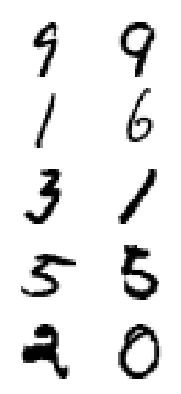

array([[1],
       [0],
       [0],
       [1],
       [0]])

In [52]:
### first task
reset_graph()
n_inputs = 28 * 28
X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)
y = tf.placeholder(tf.int32, shape=[None, 1])
# use the function "dnn" for constructing deep neural nets (defined further above)
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")
# combine the outputs in one list and check that it works (via .shape)
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)
print(dnn1.shape)
print(dnn2.shape)
print(dnn_outputs.shape)
# add an extra hidden layer with 10 neurons and an output layer with 1 neuron (sigmoid); for details, see ...
# ... https://en.wikipedia.org/wiki/Sigmoid_function
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)
# the network classifies according to y_proba > 0.5 (True or False) but this is equivalent to (and slower than) ...
# ... logits > 0 (True or False); so for classification, we use the faster logits
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)
# we still need "y_proba" to calculate the loss function (cross entropy)
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)
# training details
learning_rate = 0.01
momentum = 0.95
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)
# accuracy
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))
# initializer and saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()
### second task
# assign training sets and test set
X_train1 = X_train
y_train1 = y_train
X_train2 = X_valid
y_train2 = y_valid
X_test = X_test
y_test = y_test
# function for batches
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]
# test the function
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
print(X_batch.shape, X_batch.dtype)
# show examples
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()
# and check whether the labels match
y_batch

The labels work: different numbers have "0" label and equal numbers have a "1" label. Now, proceed to task 3 and train the network!

In [53]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))
n_epochs = 16 # changed from default 100 for brevity
batch_size = 500
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)
    save_path = saver.save(sess, "./tf_logs/11_Training/Ex_10/my_digit_comparison_model.ckpt")

0 Train loss: 0.6923601
0 Test accuracy: 0.5031
1 Train loss: 0.6937516
2 Train loss: 0.68896145
3 Train loss: 0.6279489
4 Train loss: 0.52220035
5 Train loss: 0.53943956
5 Test accuracy: 0.7317
6 Train loss: 0.540305
7 Train loss: 0.4539397
8 Train loss: 0.45064873
9 Train loss: 0.46825847
10 Train loss: 0.35033742
10 Test accuracy: 0.8226
11 Train loss: 0.41334054
12 Train loss: 0.36943892
13 Train loss: 0.3761535
14 Train loss: 0.32001543
15 Train loss: 0.3276174
15 Test accuracy: 0.8599


For the fourth task, restore the previous model and freeze its lower layers via the `tf.stop_gradient()` function. Train the output layer on only 500 images!

In [54]:
reset_graph()
n_inputs = 28 * 28
n_outputs = 10
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)
logits = tf.layers.dense(frozen_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
init = tf.global_variables_initializer()
dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()
n_epochs = 101 # adapted from default 100
batch_size = 50
X_train3 = X_train2[:500] # own code: use only 500 instances
with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./tf_logs/11_Training/Ex_10/my_digit_comparison_model.ckpt")
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train3)) # own code: use X_train3
        for rnd_indices in np.array_split(rnd_idx, len(X_train3) // batch_size): # own code: use X_train3
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)
    # "saver" shown on github but deleted here (deleted only in this session)

INFO:tensorflow:Restoring parameters from ./tf_logs/11_Training/Ex_10/my_digit_comparison_model.ckpt
0 Test accuracy: 0.3087
10 Test accuracy: 0.7337
20 Test accuracy: 0.7637
30 Test accuracy: 0.7821
40 Test accuracy: 0.7881
50 Test accuracy: 0.7922
60 Test accuracy: 0.7959
70 Test accuracy: 0.8
80 Test accuracy: 0.8022
90 Test accuracy: 0.8041
100 Test accuracy: 0.8067


Now, compare the above model with a new network trained from scratch.

In [55]:
reset_graph()
n_inputs = 28 * 28  # MNIST
n_outputs = 10
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
dnn_outputs = dnn(X, name="DNN_A")
logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
init = tf.global_variables_initializer()
dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
# "saver" shown on github but deleted here and in session
n_epochs = 101 # adapted from default 150 (for better comparison with above model)
batch_size = 50
X_train3 = X_train2[:500] # own code: use only 500 instances
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train3)) # own code: use X_train3
        for rnd_indices in np.array_split(rnd_idx, len(X_train3) // batch_size): # own code: use X_train3
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

0 Test accuracy: 0.4664
10 Test accuracy: 0.8242
20 Test accuracy: 0.8286
30 Test accuracy: 0.8287
40 Test accuracy: 0.8278
50 Test accuracy: 0.8274
60 Test accuracy: 0.8275
70 Test accuracy: 0.8273
80 Test accuracy: 0.8271
90 Test accuracy: 0.8272
100 Test accuracy: 0.827


Here, the newly trained model performs better!<br>
Bottom line: **transfer learning** can be **extremely useful** but it is **not guaranteed to work better** for every project.